# 0.0. IMPORTS

In [110]:
import math
import numpy  as np
import pandas as pd
import random
import pickle
import warnings
import inflection
import seaborn as sns
import xgboost as xgb
import datetime
import requests
import matplotlib.ticker as ticker

from scipy                 import stats  as ss
from boruta                import BorutaPy
from matplotlib            import pyplot as plt
from IPython.display       import Image
from IPython.core.display  import HTML


from sklearn.metrics       import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.ensemble      import RandomForestRegressor
from sklearn.linear_model  import LinearRegression, Lasso
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder

warnings.filterwarnings( 'ignore' )

## 0.1. Funções Auxiliares

In [2]:
def cross_validation( x_training, kfold, model_name, model, verbose=False ):
    mae_list = []
    mape_list = []
    rmse_list = []
    for k in reversed( range( 1, kfold+1 ) ):
        if verbose:
            print( '\nKFold Number: {}'.format( k ) )
        # start and end date for validation 
        validation_start_date = x_training['date'].max() - datetime.timedelta( days=k*6*7)
        validation_end_date = x_training['date'].max() - datetime.timedelta( days=(k-1)*6*7)

        # filtering dataset
        training = x_training[x_training['date'] < validation_start_date]
        validation = x_training[(x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date)]

        # training and validation dataset
        # training
        xtraining = training.drop( ['date', 'sales'], axis=1 ) 
        ytraining = training['sales']

        # validation
        xvalidation = validation.drop( ['date', 'sales'], axis=1 )
        yvalidation = validation['sales']

        # model
        m = model.fit( xtraining, ytraining )

        # prediction
        yhat = m.predict( xvalidation )

        # performance
        m_result = ml_error( model_name, np.expm1( yvalidation ), np.expm1( yhat ) )

        # store performance of each kfold iteration
        mae_list.append(  m_result['MAE'] )
        mape_list.append( m_result['MAPE'] )
        rmse_list.append( m_result['RMSE'] )

    return pd.DataFrame( {'Model Name': model_name,
                          'MAE CV': np.round( np.mean( mae_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( mae_list ), 2 ).astype( str ),
                          'MAPE CV': np.round( np.mean( mape_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( mape_list ), 2 ).astype( str ),
                          'RMSE CV': np.round( np.mean( rmse_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( rmse_list ), 2 ).astype( str ) }, index=[0] )


def mean_percentage_error( y, yhat ):
    return np.mean( ( y - yhat ) / y )
     
    
def mean_absolute_percentage_error( y, yhat ):
    return np.mean( np.abs( ( y - yhat ) / y ) )

    
def ml_error( model_name, y, yhat ):
    mae = mean_absolute_error( y, yhat )
    mape = mean_absolute_percentage_error( y, yhat )
    rmse = np.sqrt( mean_squared_error( y, yhat ) )
    
    return pd.DataFrame( { 'Model Name': model_name, 
                           'MAE': mae, 
                           'MAPE': mape,
                           'RMSE': rmse }, index=[0] )

def cramer_v( x, y ):
    cm = pd.crosstab( x, y ).values
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency( cm )[0]
    chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) )
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt( (chi2corr/n) / ( min( kcorr-1, rcorr-1 ) ) )



def jupyter_settings():
        
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
        
    sns.set()

In [3]:
jupyter_settings()

## 0.2. Carregamento dos dados

In [4]:
df_sales_raw = pd.read_csv( 'train.csv', low_memory=False )
df_store_raw = pd.read_csv( 'store.csv', low_memory=False )

# merge
df_raw = pd.merge( df_sales_raw, df_store_raw, how='left', on='Store' )

# 1.0 - DESCRICAO DOS DADOS

In [51]:
#cópia do df original para não precisar rodar o notebook inteiro.
df1 = df_raw.copy()

In [52]:
df1.head(2)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"


**Id** - Identificação única da loja.

**Sales** - O valor vendido para o dia (Variável que realizaremos a predição)

**Customers** - Quantidade de clientes que visitaram a loja em um dia

**Open** - indica se a loja abriu ou não: 0 = fechada, 1 = aberta

**StateHoliday** - Indica feriado estadual. a = public holiday, b = Easter holiday, c = Christmas, 0 = None

**SchoolHoliday** - Indica se a loja foi afetada por um feriado escolar

**StoreType** - Diferencia os 4 tipos de loja: a, b, c, d

**Assortment** - Descreve o nível de sortimento de produtos da loja: a = basic, b = extra, c = extended

**CompetitionDistance** - Distância do competidor mais próximo

**CompetitionOpenSince[Month/Year]** - Fornece o ano e o mês aproximados em que o concorrente mais próximo foi aberto

**Promo** - Indica se uma loja está realizando uma promoção naquele dia

**Promo2** - É uma promoção contínua e consecutiva para algumas lojas: 0 = a loja não está participando, 1 = a loja está participando

**Promo2Since[Year/Week]** - Descreve o ano e a semana do calendário em que a loja começou a participar da Promo2

**PromoInterval** - Descreve os intervalos consecutivos em que a Promo2 é iniciada, nomeando os meses em que a promoção é iniciada novamente.

## 1.1 - Renomeando Colunas

In [53]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday', 
            'StoreType', 'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth',
            'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore( x )

cols_new = list( map( snakecase, cols_old ) )

# rename
df1.columns = cols_new

## 1.2 - Dimensões do DataSet

In [54]:
print( 'Number of Rows: {}'.format( df1.shape[0] ) )
print( 'Number of Cols: {}'.format( df1.shape[1] ) )

Number of Rows: 1017209
Number of Cols: 18


## 1.3 - Checagem de valores nulos

In [55]:
#verificando a quantidade de valores nulos
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.4 - Substituindo valores nulos

In [57]:
#alterando a coluna date para formato de data.
df1['date'] = pd.to_datetime( df1['date'] )
#competition_distance
#por haver 2642 dados vazios, considerarei que não há comperidores proxímos, por isso substituirei os NA por um valor muito alto.
df1['competition_distance'] = df1['competition_distance'].apply( lambda x: 300000.0 if math.isnan( x ) else x )

#Possíveis razões para que essa coluna esteja vazia: 
## a loja não tem competidor próximo, a loja abriu antes da nossa ou alguém esqueceu de anotar caso seja um processo manual.
## como eu tenho um competition_distance quer dizer que eu tenho um competidor, só não sei quando ele abriu, então não posso substituir por 0
### vou colocar a data da abertura da minha loja na data da abertura da loja do concorrente.
df1['competition_open_since_month'] = df1.apply( lambda x: x['date'].month if math.isnan( x['competition_open_since_month'] ) else x['competition_open_since_month'], axis=1 )


#mesma ideia da coluna acima.
df1['competition_open_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['competition_open_since_year'] ) else x['competition_open_since_year'], axis=1 )

#promo2_since_week(descreve o ano e a semana quando a loja começou a participar da promo2, promo2 é a continuação de uma promoção de algumas lojas)
## o NA pode significar que a loja decidiu não participar da promoção
## vou substituir o NA pelo valor da data naquela linha
df1['promo2_since_week'] = df1.apply( lambda x: x['date'].week if math.isnan( x['promo2_since_week'] ) else x['promo2_since_week'], axis=1 )

#mesma ideia da coluna acima.
df1['promo2_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['promo2_since_year'] ) else x['promo2_since_year'], axis=1 )

#promo_interval(meses que a promo2 ficou ativa)
#criar um dicionário com os meses.
month_map = {1: 'Jan',  2: 'Feb',  3: 'Mar',  4: 'Apr',  5: 'May',  6: 'Jun',  7: 'Jul',  8: 'Aug',  9: 'Sept',  10: 'Oct', 11: 'Nov', 12: 'Dec'}

#se for NA substitui por 0 pois significa que não teve promoções.
df1['promo_interval'].fillna(0, inplace=True )

# pega a o mes da coluna date e joga na coluna month_map, ou seja, traduz a data em mês.
df1['month_map'] = df1['date'].dt.month.map( month_map )

#cria uma coluna is_promo pra dizer se a loja participou da promoção.
#verifica se o mes da coluna month_map está contida na coluna promo_interval
df1['is_promo'] = df1[['promo_interval', 'month_map']].apply( lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split( ',' ) else 0, axis=1 )


## 1.5 - Conversão dos tipos de dados

In [58]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [59]:
# convertendo as colunas criadas de flot para int.
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype( 'int64' )
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype( 'int64' )
df1['promo2_since_week'] = df1['promo2_since_week'].astype( 'int64' )
df1['promo2_since_year'] = df1['promo2_since_year'].astype( 'int64' )

## 1.6 - Estatística Descritiva

In [60]:
#criando duas variáveis, umas para as variáveis numéricas e outra para as variáveis categóricas.
num_attributes = df1.select_dtypes( include=['int64', 'float64'] )
cat_attributes = df1.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'] )

### 1.6.1 - Variáveis numéricas

In [61]:
num_attributes.agg(['mean', 'median', 'std', 'min', 'max', 'skew', 'kurtosis']).T.reset_index().rename(columns={'index':'attributes'})

,attributes,mean,median,std,min,max,skew,kurtosis
0,store,558.429727,558.0,321.908651,1.0,1115.0,-0.000955,-1.200524
1,day_of_week,3.998341,4.0,1.997391,1.0,7.0,0.001593,-1.246873
2,sales,5773.818972,5744.0,3849.926175,0.0,41551.0,0.641460,1.778375
3,customers,633.145946,609.0,464.411734,0.0,7388.0,1.598650,7.091773
4,open,0.830107,1.0,0.375539,0.0,1.0,-1.758045,1.090723
5,promo,0.381515,0.0,0.485759,0.0,1.0,0.487838,-1.762018
6,school_holiday,0.178647,0.0,0.383056,0.0,1.0,1.677842,0.815154
7,competition_distance,6195.172978,2330.0,16856.992094,20.0,300000.0,14.003340,237.337110
8,competition_open_since_month,6.786849,7.0,3.311087,1.0,12.0,-0.042076,-1.232607
9,competition_open_since_year,2010.324840,2012.0,5.515593,1900.0,2015.0,-7.235657,124.071304


### 1.6.2 - Variáveis categóricas

In [62]:
cat_attributes.apply( lambda x: x.unique().shape[0] )

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

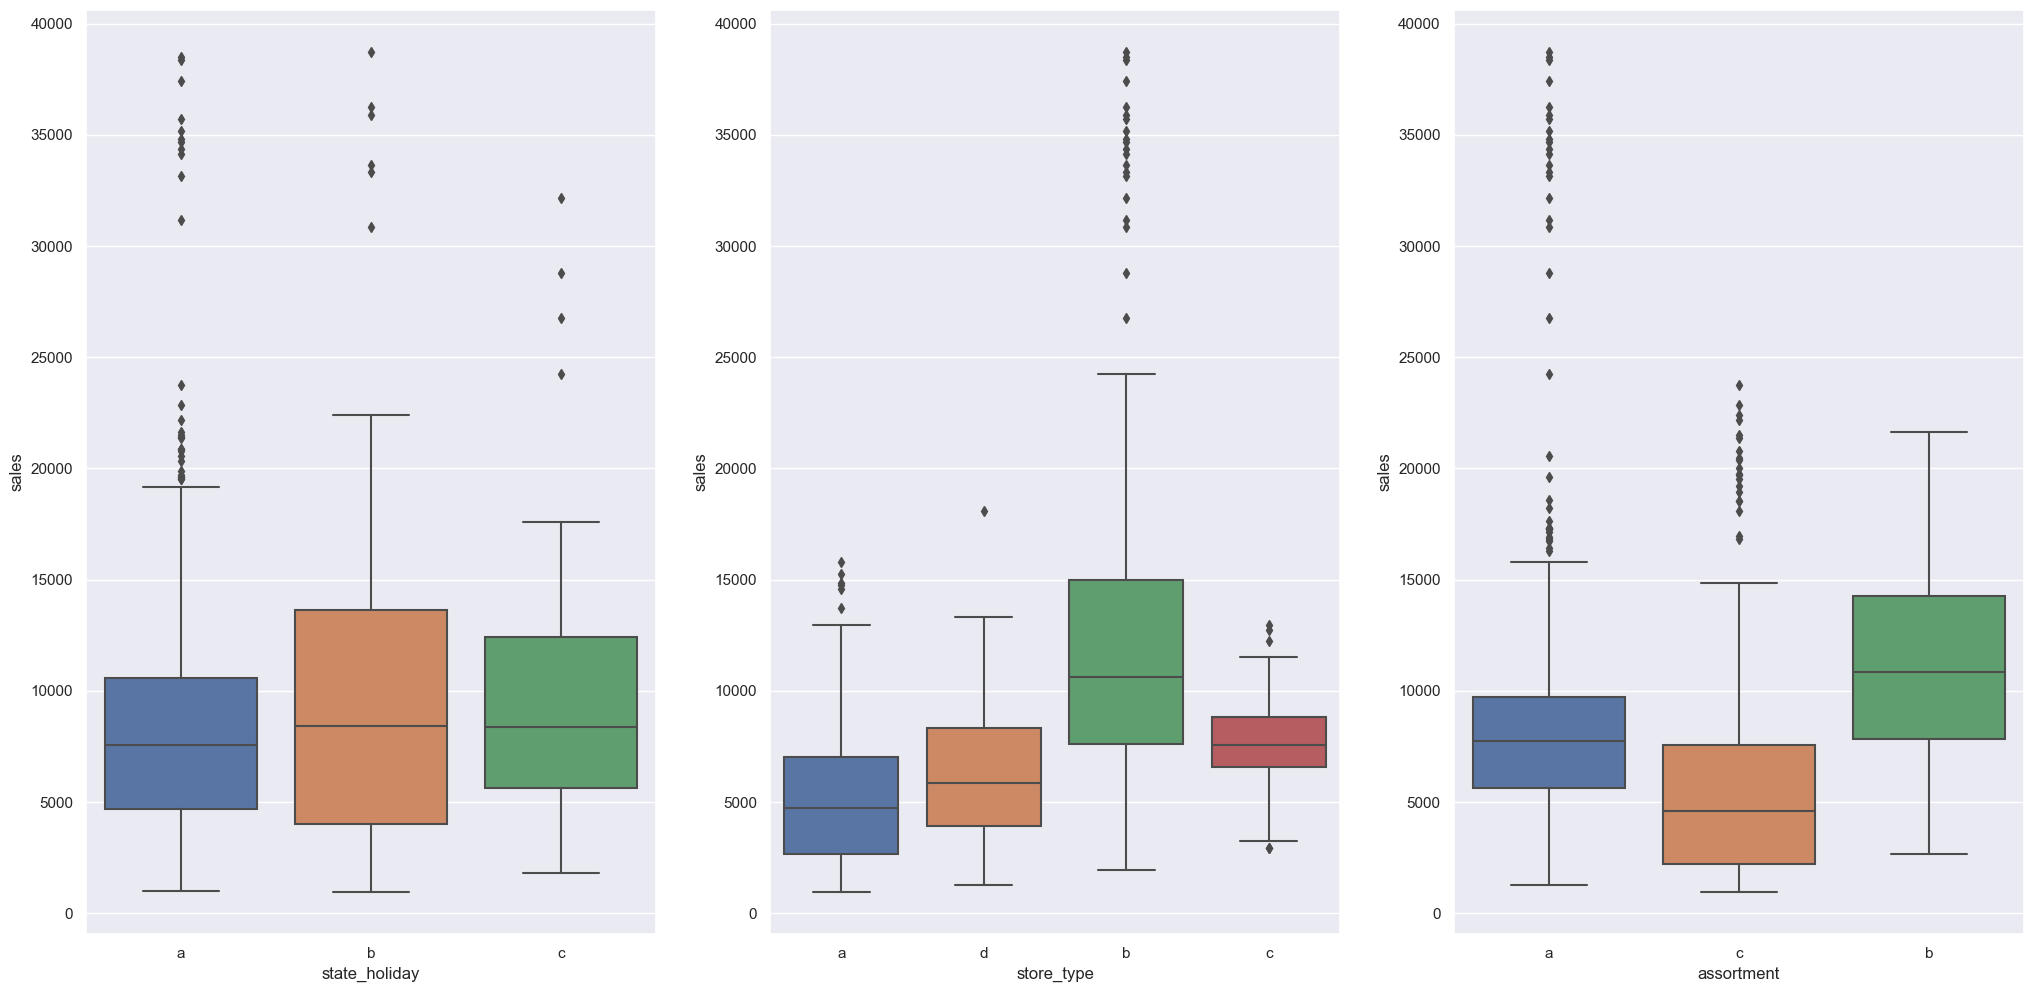

In [63]:
aux = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)] #removendo vendas menores que 0 e dias regulares.

plt.subplot( 1, 3, 1 )
sns.boxplot( x='state_holiday', y='sales', data=aux )

plt.subplot( 1, 3, 2 )
sns.boxplot( x='store_type', y='sales', data=aux )

plt.subplot( 1, 3, 3 )
sns.boxplot( x='assortment', y='sales', data=aux );

# 2.0 - FEATURE ENGINEERING

In [64]:
df2 = df1.copy()

## 2.1 - Hipóteses

**1.** Lojas com maior sortimentos deveriam vender mais.

**2.** Lojas com competidores mais próximos deveriam vender menos.

**3.** Lojas com competidores à mais tempo deveriam vendem mais.

**4.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**5.** Lojas com mais promoções consecutivas deveriam vender mais.

**6.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**7.** ojas deveriam vender mais ao longo dos anos.

**8.** Lojas deveriam vender mais no segundo semestre do ano.

**9.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**10.** Lojas deveriam vender menos aos finais de semana.

**11.** Lojas deveriam vender menos durante os feriados escolares.

## 2.4. Feature Engineering

In [65]:
#criação de novas variáveis para auxiliar na análise das hipóteses.
# year
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# week of year
df2['week_of_year'] = df2['date'].dt.weekofyear

# year week
df2['year_week'] = df2['date'].dt.strftime( '%Y-%W' )

# competition since
df2['competition_since'] = df2.apply( lambda x: datetime.datetime( year=x['competition_open_since_year'], month=x['competition_open_since_month'],day=1 ), axis=1 )
df2['competition_time_month'] = ( ( df2['date'] - df2['competition_since'] )/30 ).apply( lambda x: x.days ).astype( int )

# promo since
df2['promo_since'] = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str )
df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w' ) - datetime.timedelta( days=7 ) )
df2['promo_time_week'] = ( ( df2['date'] - df2['promo_since'] )/7 ).apply( lambda x: x.days ).astype( int )

# assortment
df2['assortment'] = df2['assortment'].apply( lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended' )

# state holiday
df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day' )

In [81]:
df2.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


# 3.0 - FILTRAGEM DE VARIÁVEIS

In [67]:
df3 = df2.copy()

## 3.1. Filtragem das Linhas


In [68]:
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

## 3.2. Selecao das Colunas

In [69]:
cols_drop = ['customers', 'open', 'promo_interval', 'month_map'] #removendo as colunas que não serão utilizadas
df3 = df3.drop( cols_drop, axis=1 )

# 4.0 - ANALISE EXPLORATORIA DOS DADOS (EDA)

In [70]:
df4 = df3.copy()

## 4.1. Analise Univariada

### 4.1.1 - Variável Resposta

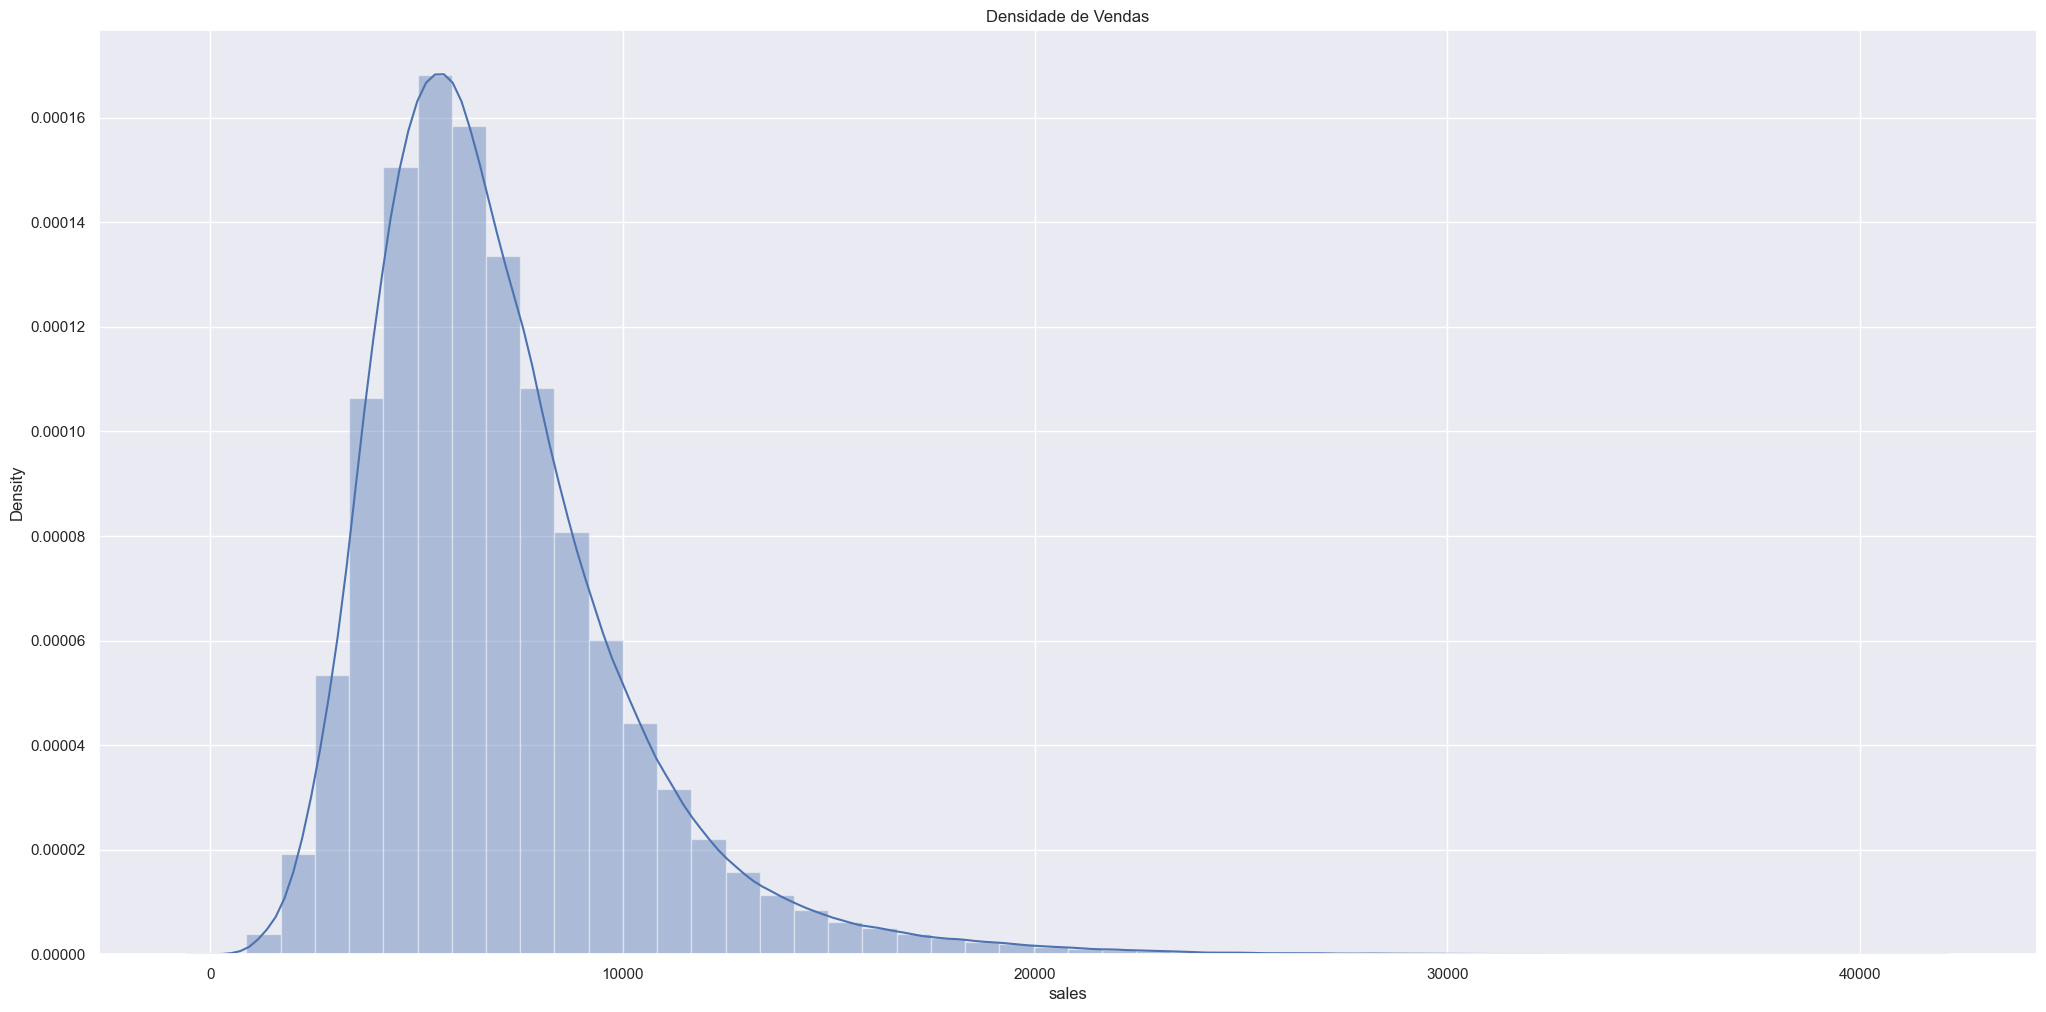

In [80]:
sns.distplot( df4['sales']).set_title('Densidade de Vendas');

### 4.1.2 - Variáveis Numéricas.

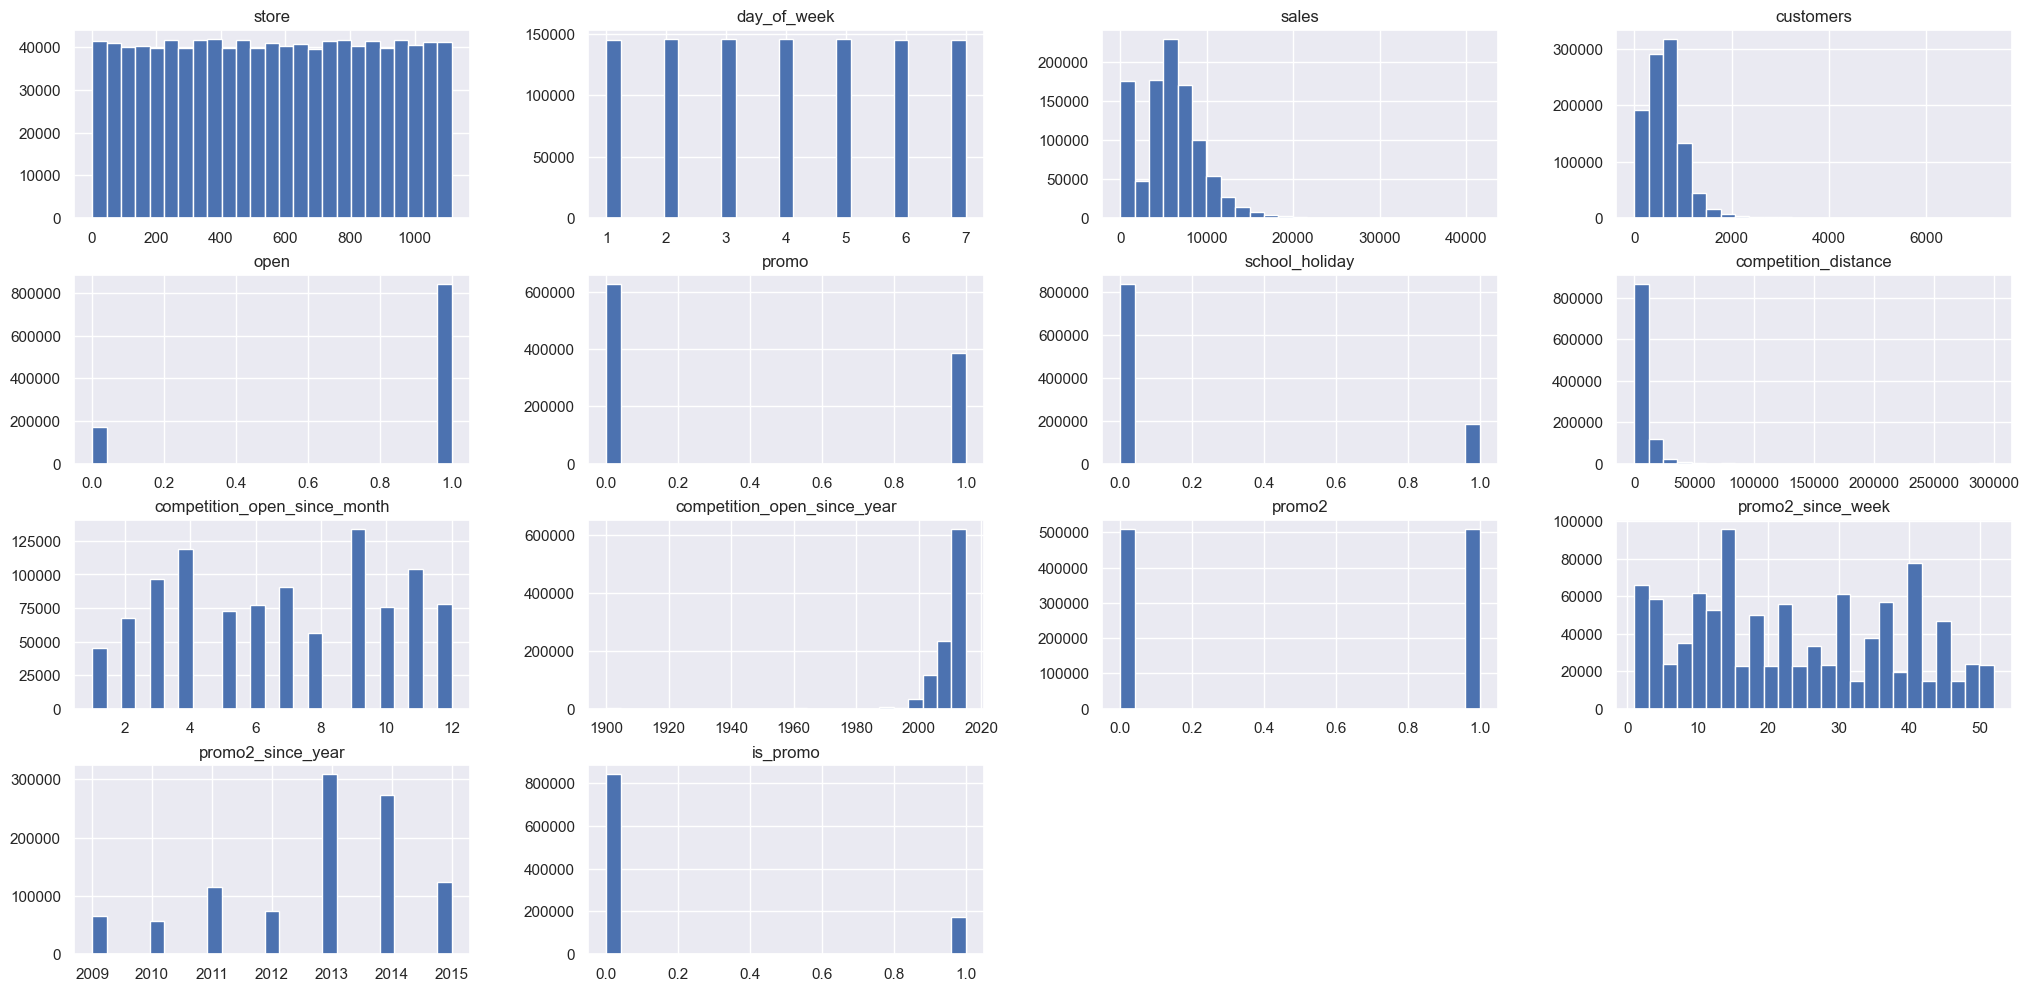

In [74]:
num_attributes.hist( bins=25 );

Com a análise dos gráficos acima podemos perceber alguns pontos, por exemplo:
Competition_distance - tenho uma concentração maior em competições menores, ou seja, meus concorrentes estão mais proximos. competition_open_since_month - tem um crescimento até o quarto mes, depois cai e no 9º mes sobre de novo.

day_of_week - tem uma distribuição quase igual, ou seja, vende praticamente a mesma quantidade nos dias da semana, então não tenho um comportamento que ajude de forma significativa no aprendizado do modelo.

### 4.1.3. Variáveis categóricas

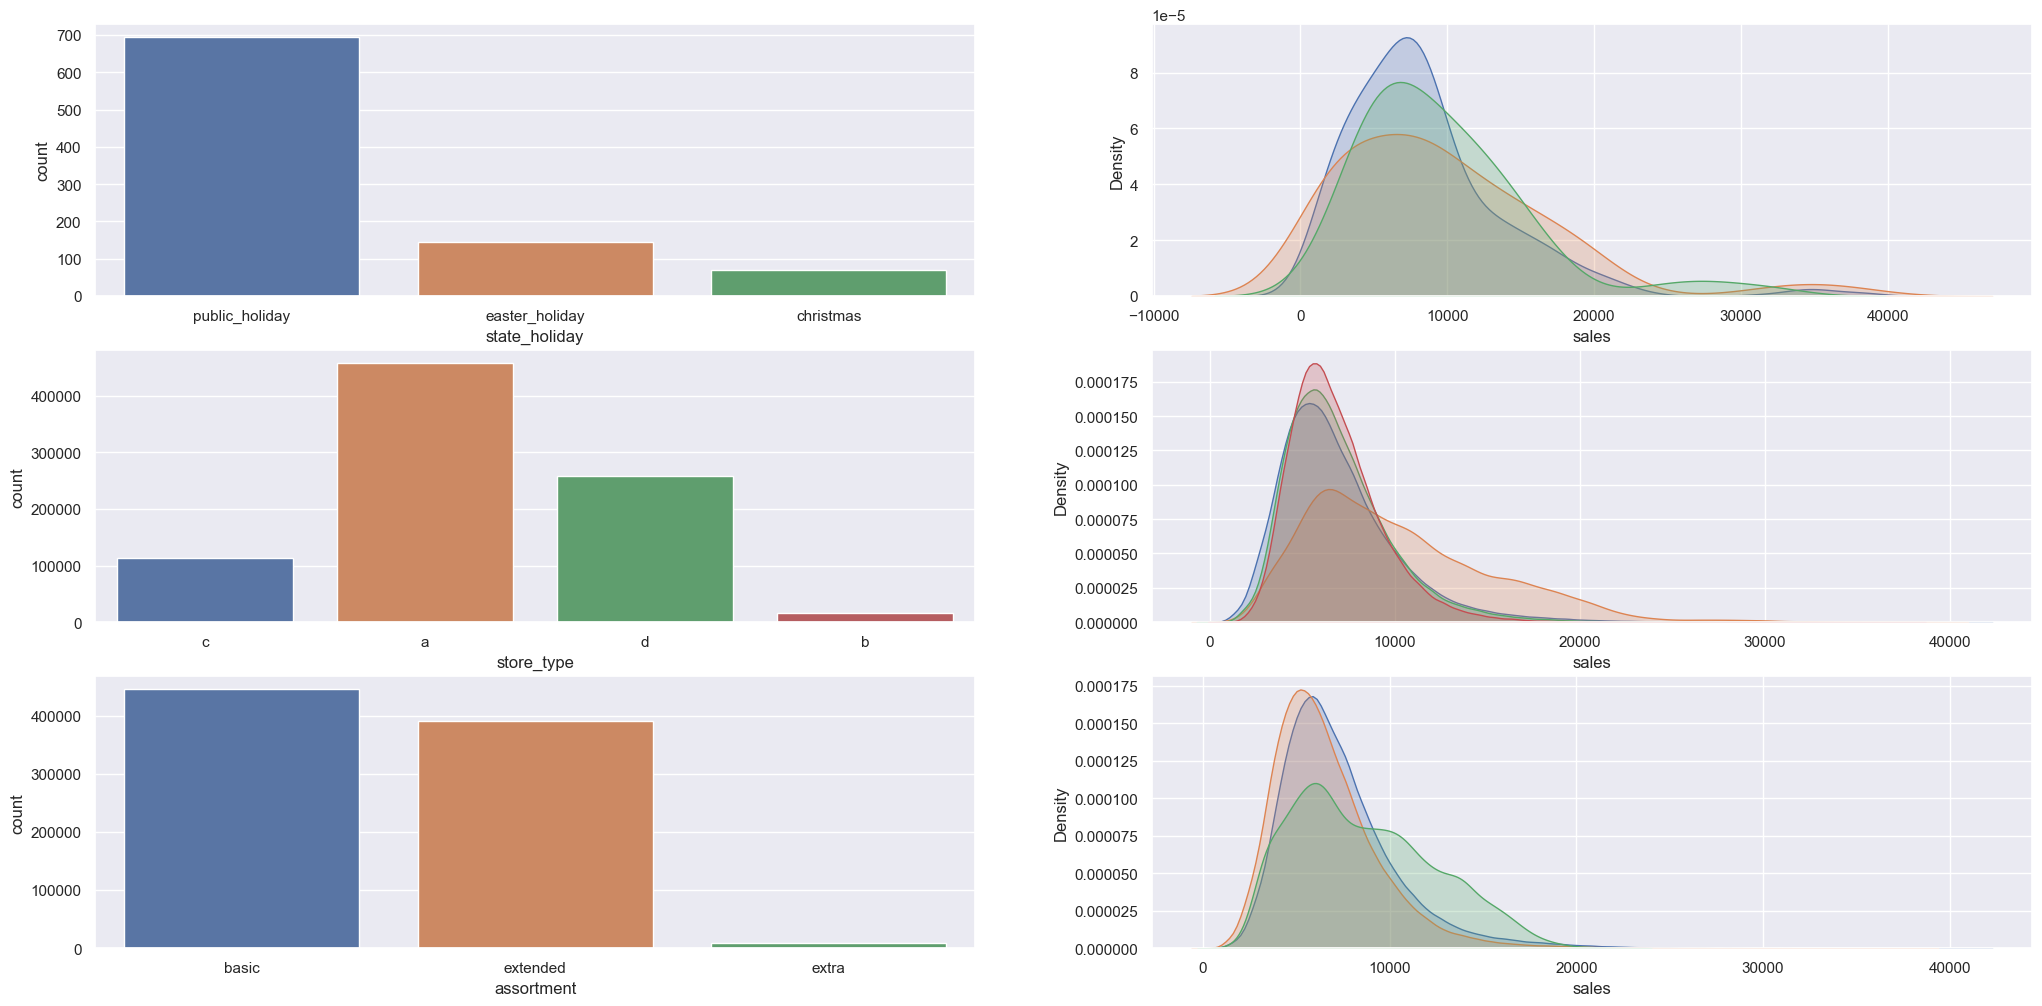

In [77]:
# state_holiday
plt.subplot(321)
a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot(a['state_holiday'])

plt.subplot(322)
sns.kdeplot(df4[df4['state_holiday'] == 'public_holiday']['sales'], label='public_holiday', shade=True)
sns.kdeplot(df4[df4['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday', shade=True)
sns.kdeplot(df4[df4['state_holiday'] == 'christmas']['sales'], label='christmas', shade=True)

# store_type
plt.subplot(323)
sns.countplot( df4['store_type'] )

plt.subplot(324)
sns.kdeplot(df4[df4['store_type'] == 'a']['sales'], label='a', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'b']['sales'], label='b', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'c']['sales'], label='c', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'd']['sales'], label='d', shade=True)

# assortment
plt.subplot(325)
sns.countplot( df4['assortment'] )

plt.subplot(326)
sns.kdeplot(df4[df4['assortment'] == 'extended']['sales'], label='extended', shade=True)
sns.kdeplot(df4[df4['assortment'] == 'basic']['sales'], label='basic', shade=True)
sns.kdeplot(df4[df4['assortment'] == 'extra']['sales'], label='extra', shade=True);

## 4.2. Analise Bivariada

### H1 - Lojas com maior sortimento deveriam vender mais.
**VERDADEIRA**

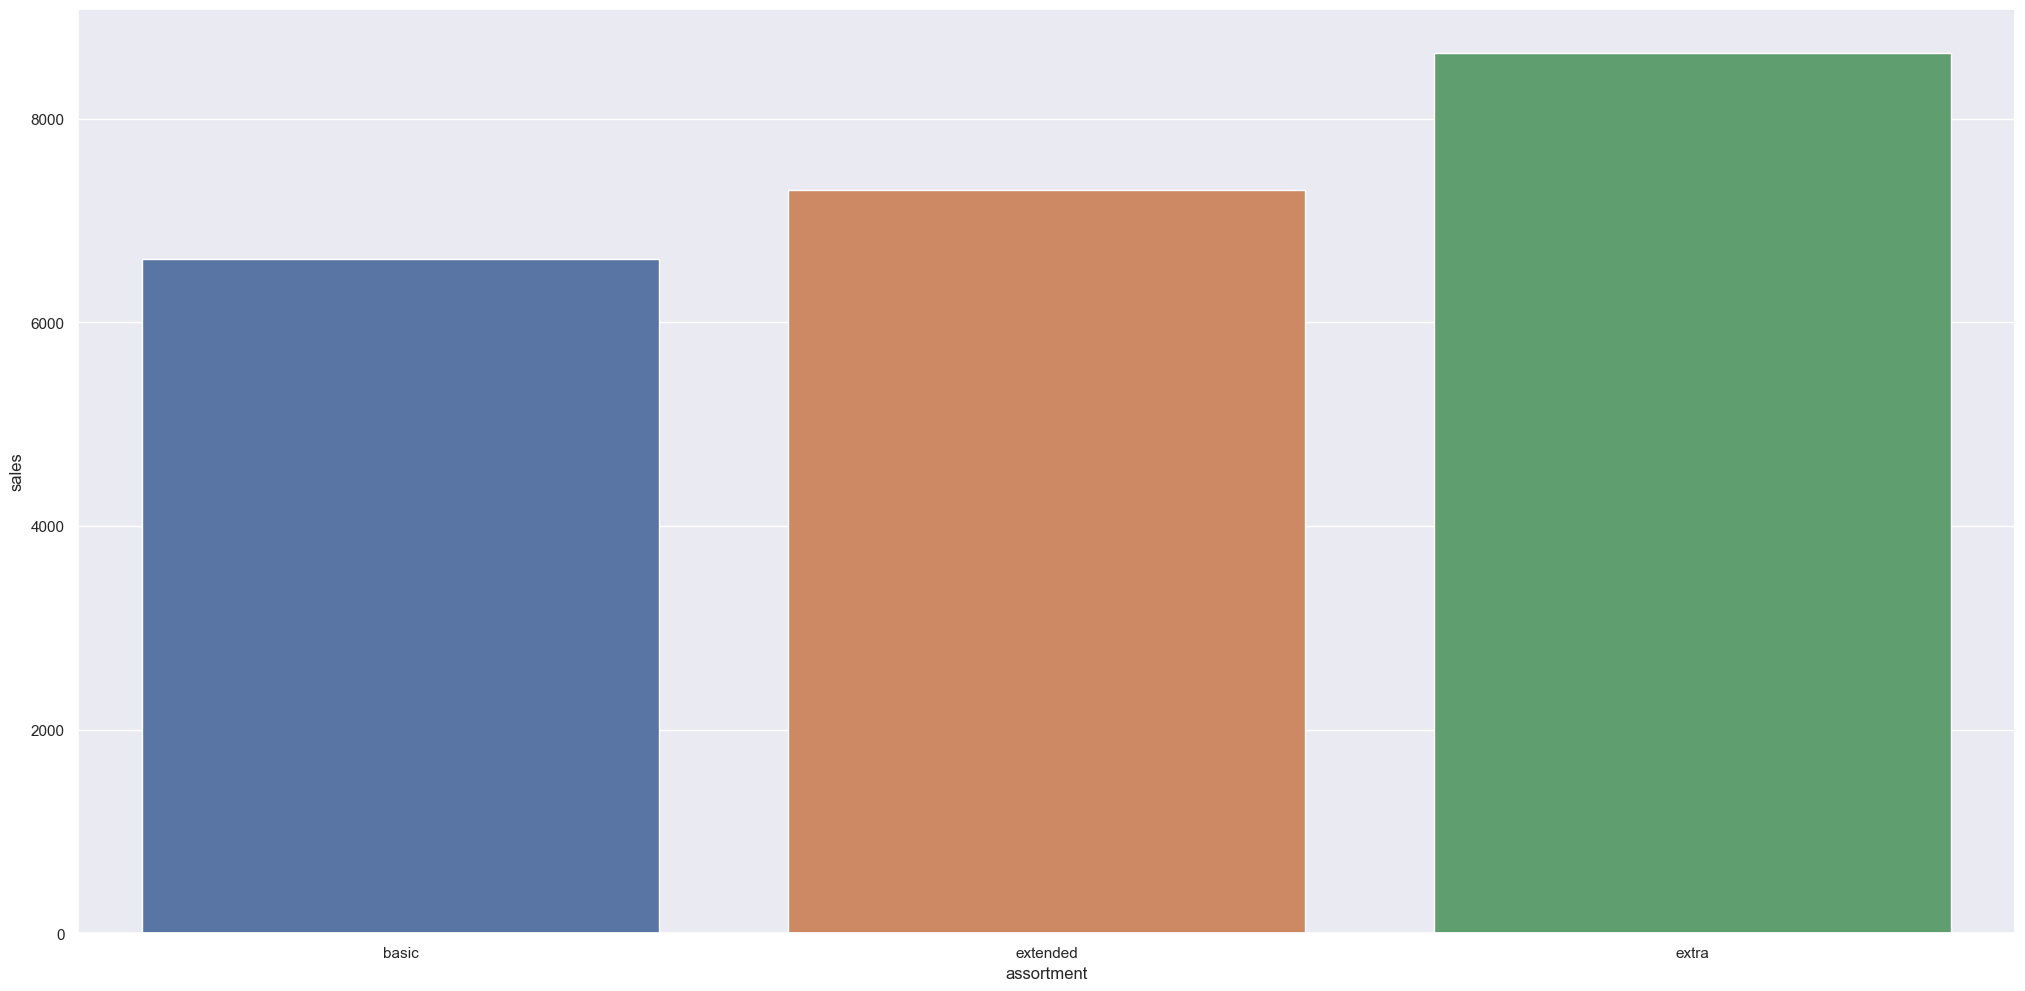

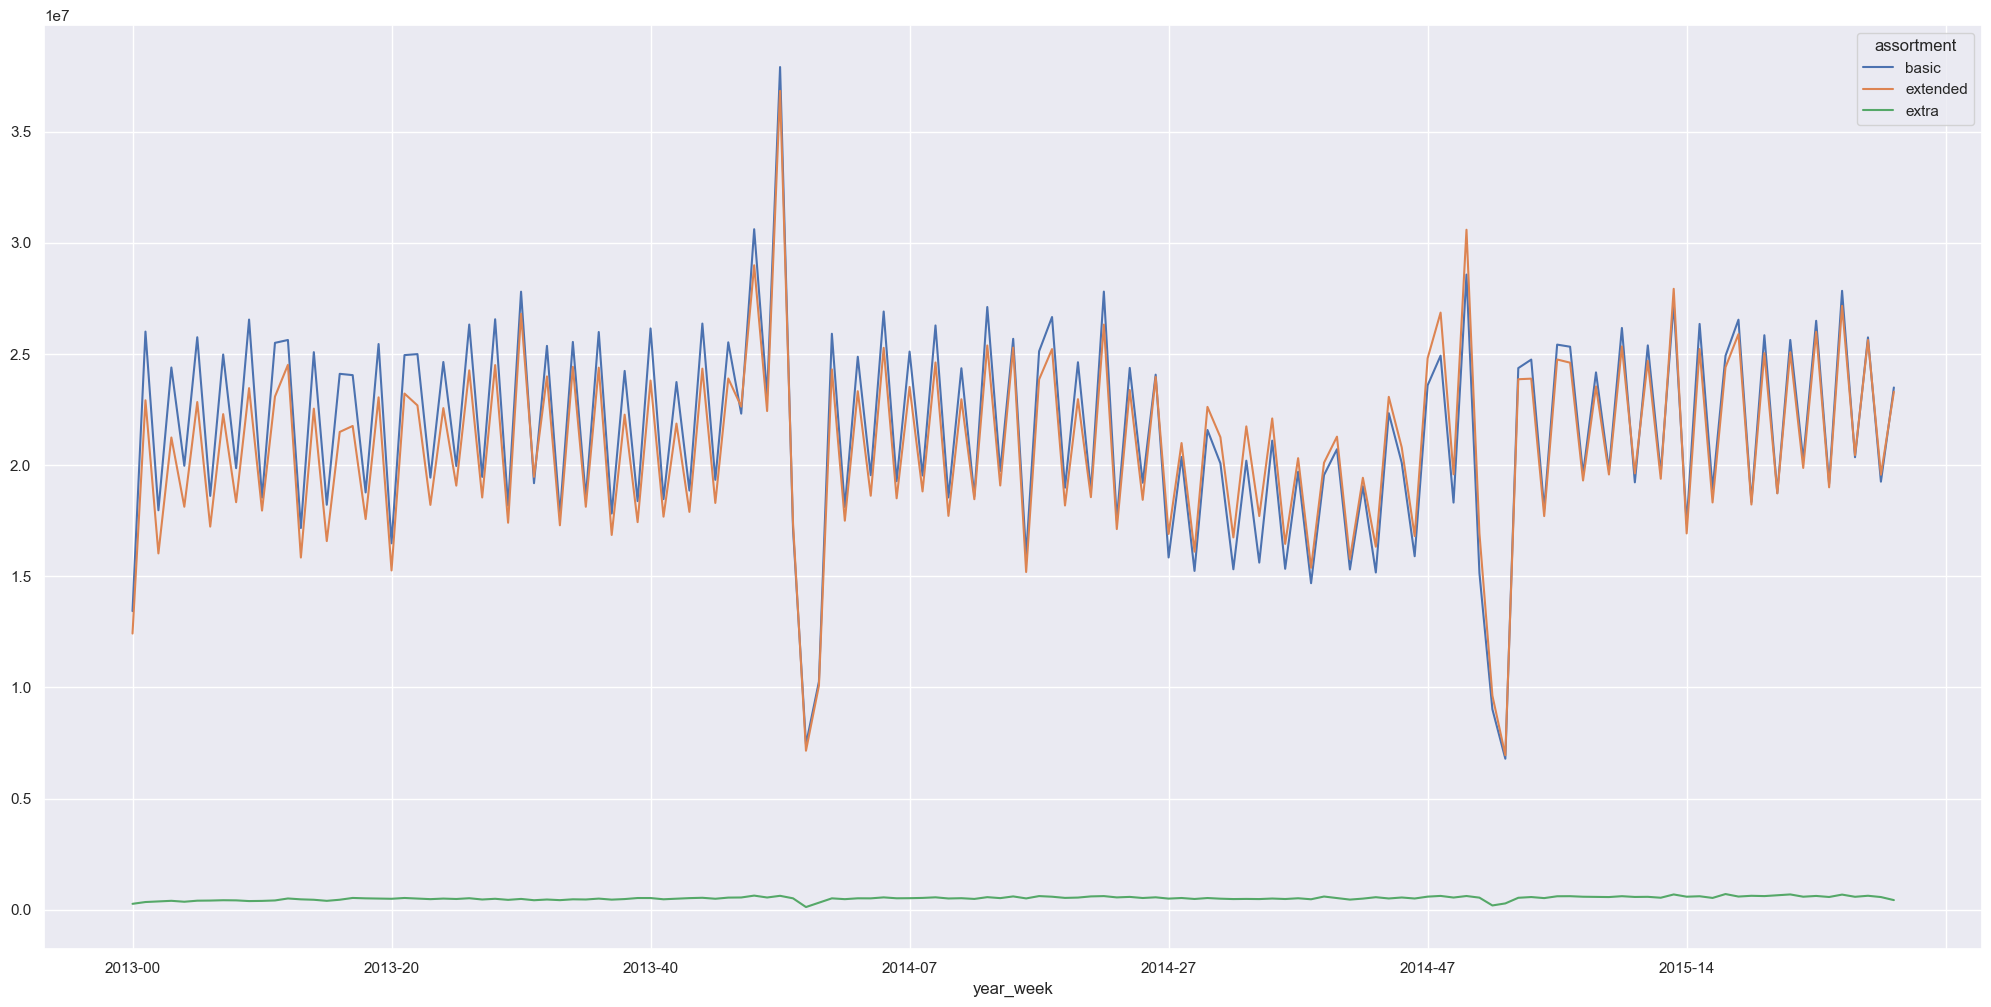

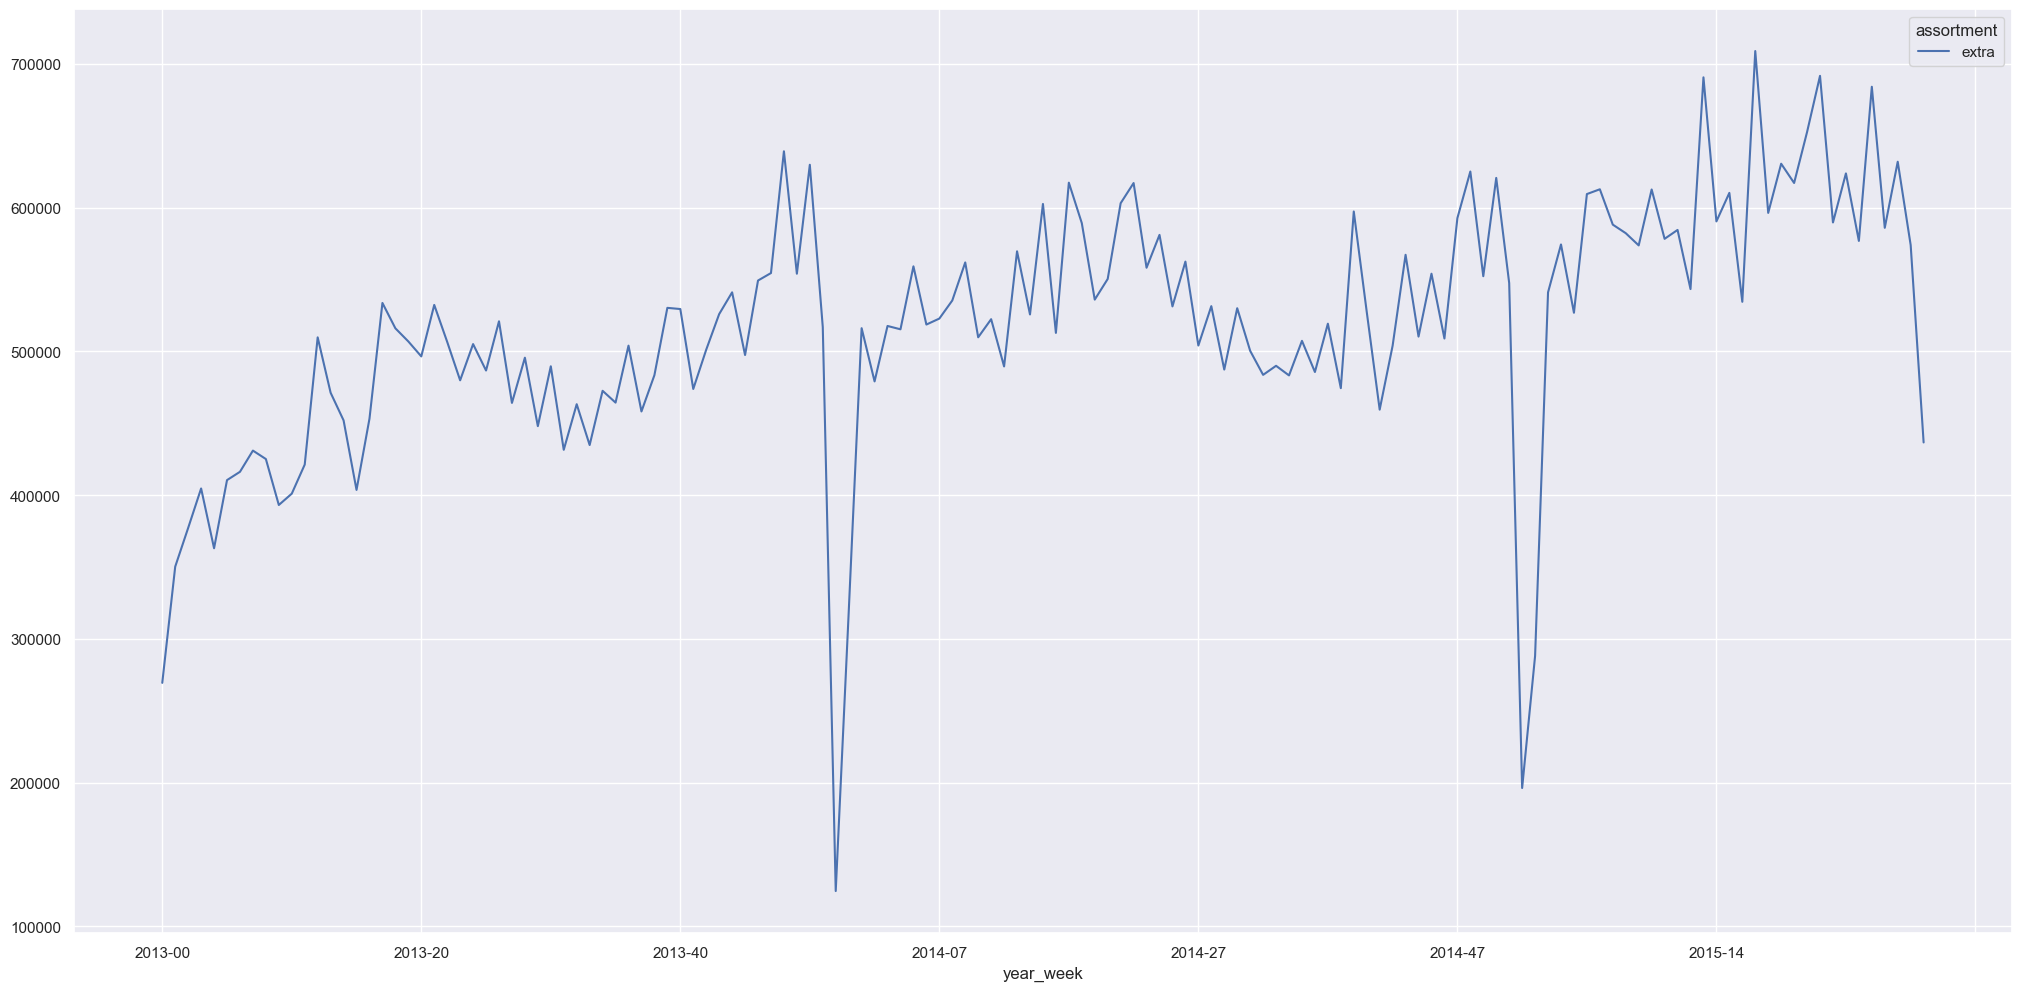

In [85]:
aux1 = df4[['assortment', 'sales']].groupby('assortment').mean().reset_index()
sns.barplot(x='assortment', y='sales', data=aux1);

aux2 = df4[['year_week', 'assortment', 'sales']].groupby( ['year_week','assortment'] ).sum().reset_index()
aux2.pivot(index='year_week', columns='assortment', values='sales').plot()

aux3 = aux2[aux2['assortment'] == 'extra']
aux3.pivot(index='year_week', columns='assortment', values='sales').plot();

### H2 - Lojas com competidores mais próximos deveriam vender menos.
**FALSA** 

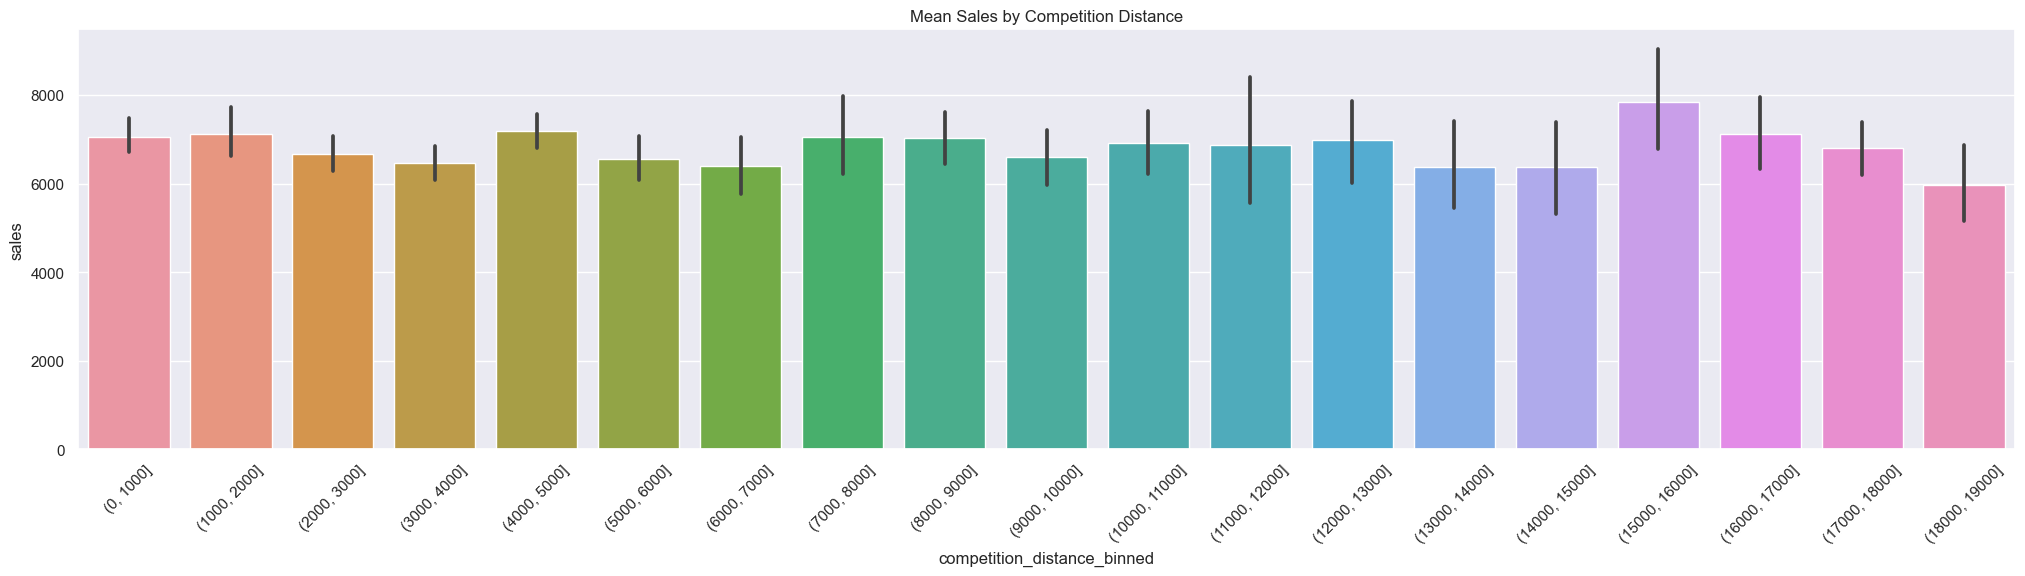

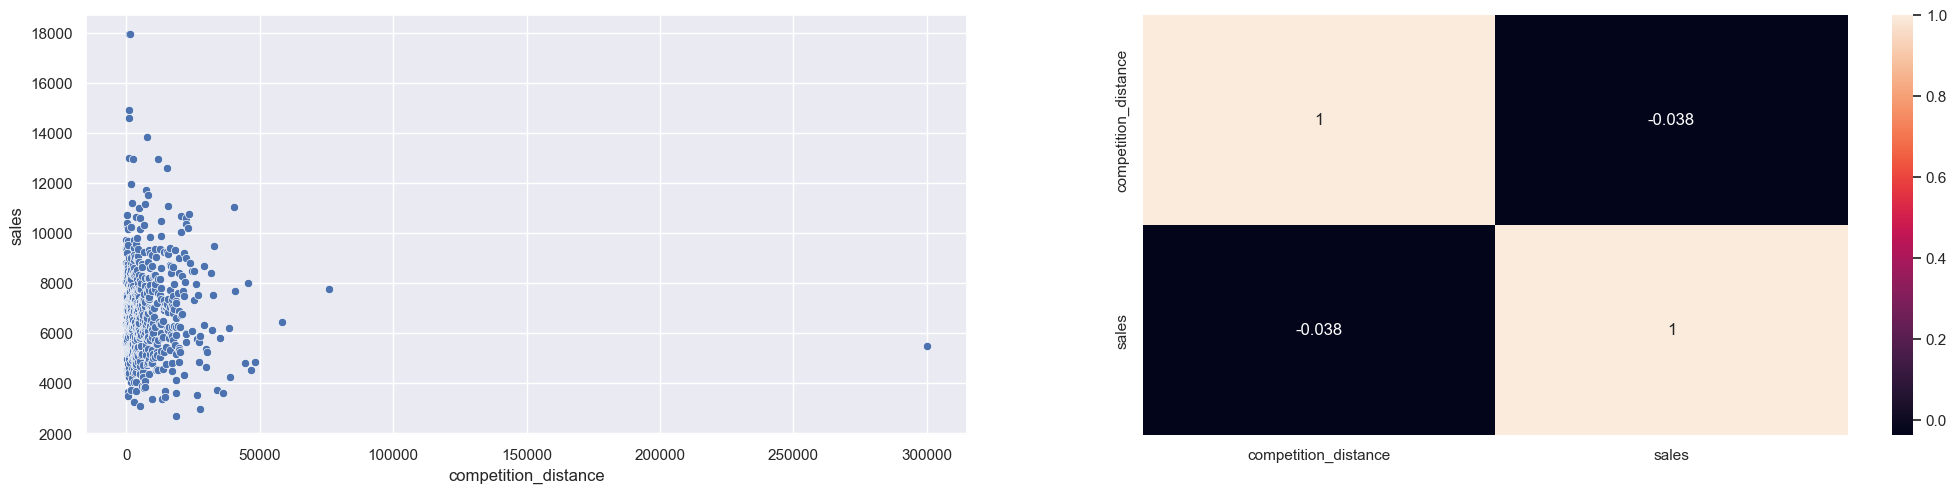

In [89]:
bins = list(np.arange(0,20000,1000))
grid = plt.GridSpec(2,2)

aux2 = df4[['competition_distance', 'sales']].groupby('competition_distance').mean().reset_index()

aux2['competition_distance_binned'] = pd.cut( aux2['competition_distance'], bins=bins)

plt.subplot(grid[0,:])
ax = sns.barplot(x='competition_distance_binned', y='sales', data=aux2).set_title('Mean Sales by Competition Distance')
plt.xticks(rotation=45)
plt.show()


grid = plt.GridSpec(2,2)

plt.subplot(grid[0,0])
sns.scatterplot(x='competition_distance', y='sales', data=aux2)

plt.subplot(grid[0,1])
sns.heatmap(aux2[['competition_distance', 'sales']].corr(method='pearson'), annot=True)
plt.show()

### H3 - Lojas com competidores à mais tempo deveriam vendem mais.
**FALSA** 

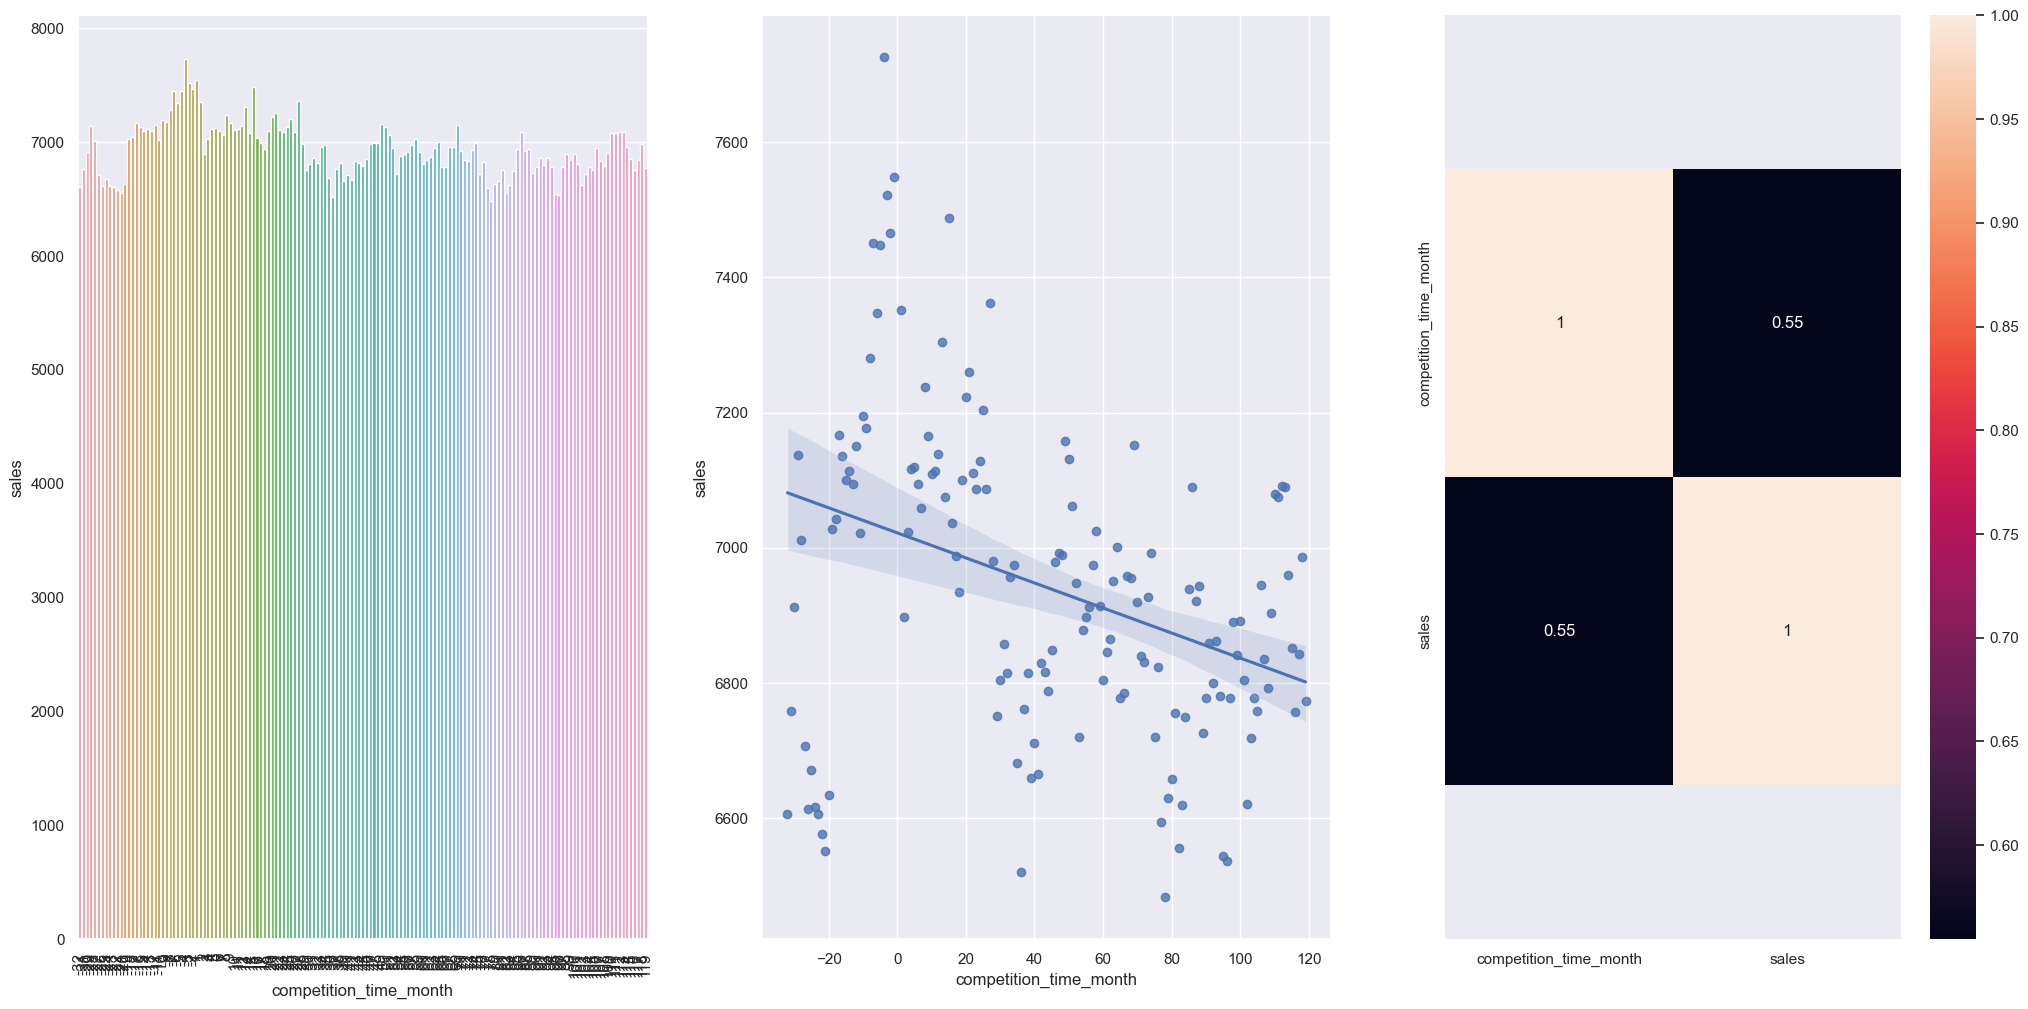

In [91]:
plt.subplot(131)
aux1 = df4[['competition_time_month', 'sales']].groupby( 'competition_time_month' ).mean().reset_index()
aux2 = aux1[( aux1['competition_time_month'] < 120 ) & ( aux1['competition_time_month'] != 0 )]
sns.barplot( x='competition_time_month', y='sales', data=aux2 );
plt.xticks( rotation=90 );

plt.subplot(132)
sns.regplot( x='competition_time_month', y='sales', data=aux2 );

plt.subplot(133)
x = sns.heatmap( aux1.corr( method='pearson'), annot=True );
bottom, top = x.get_ylim()
x.set_ylim( bottom+0.5, top-0.5);

### H4 - Lojas com promoções ativas por mais tempo deveriam vender mais.
**VERDADEIRA** 

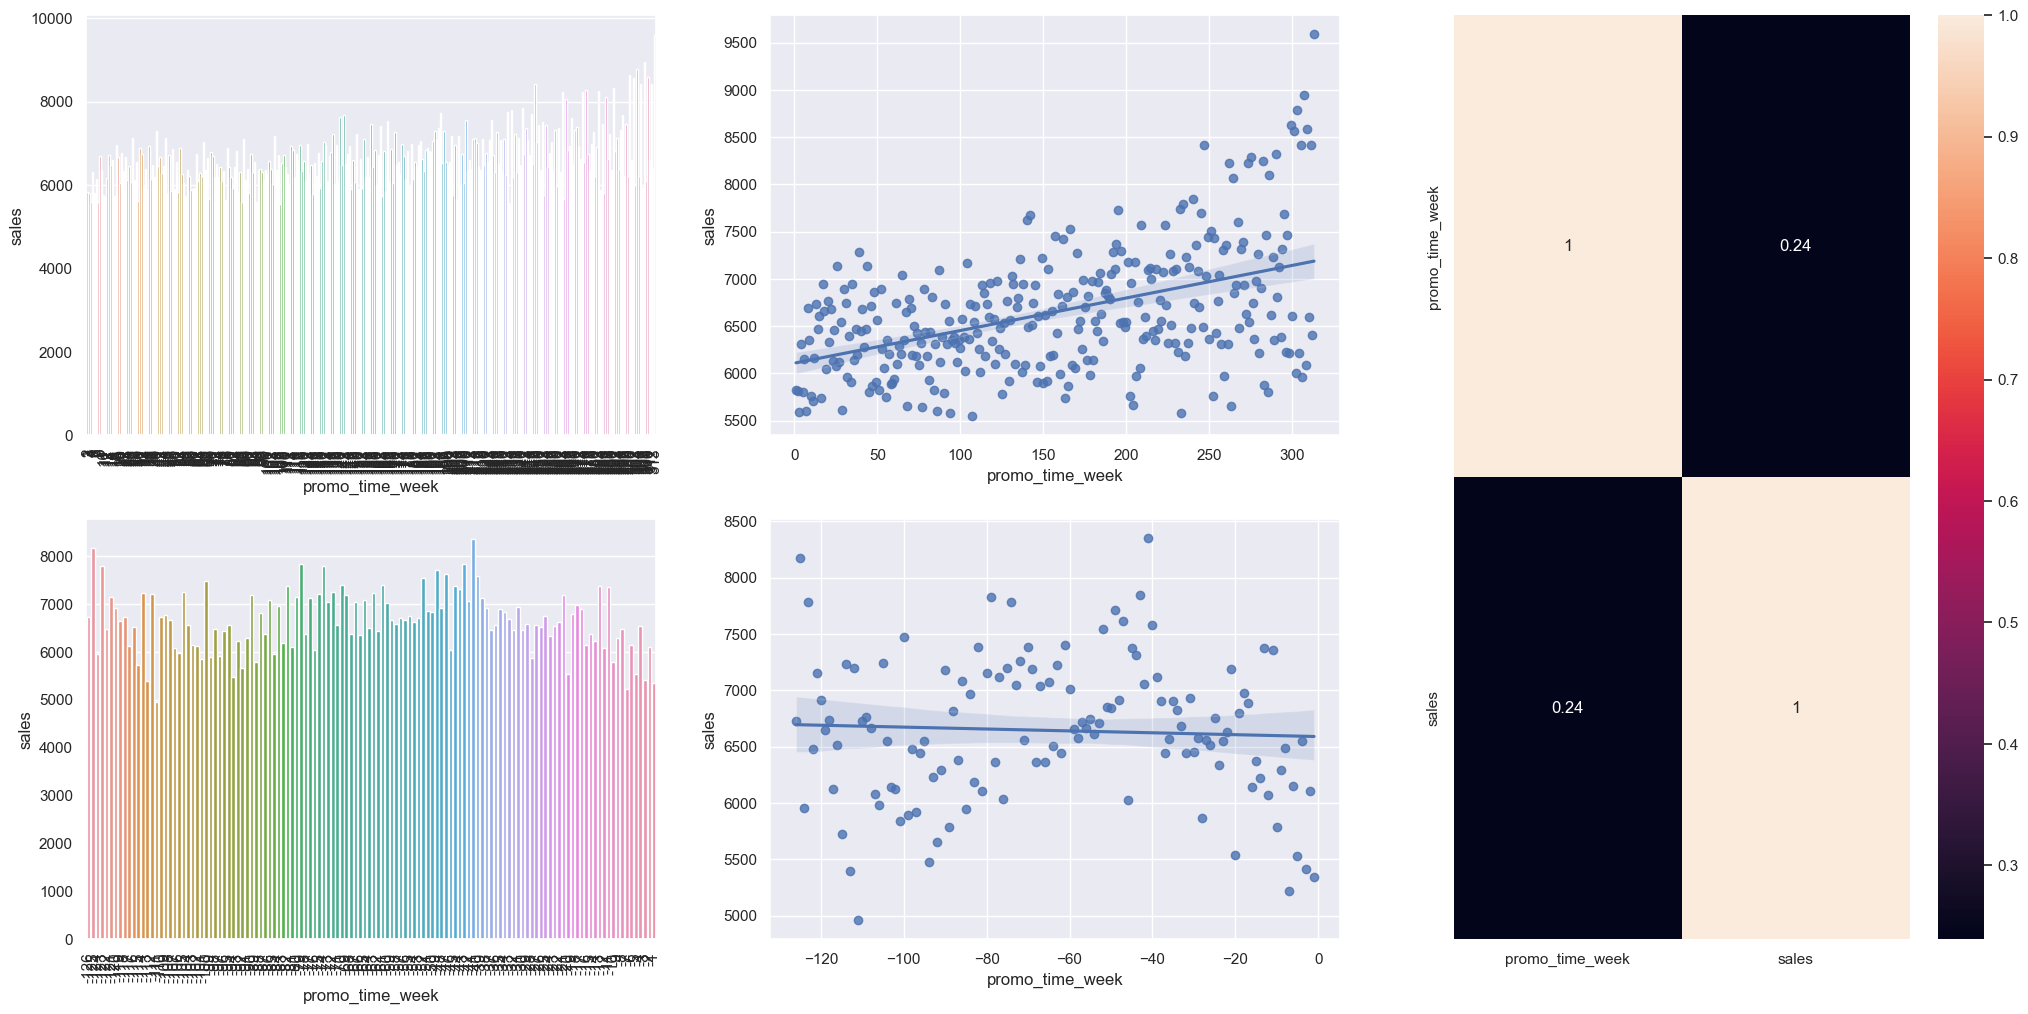

In [108]:
aux1 = df4[['promo_time_week', 'sales']].groupby( 'promo_time_week').mean().reset_index()

grid = plt.GridSpec( 2, 3 )

plt.subplot( grid[0,0] )
aux2 = aux1[aux1['promo_time_week'] > 0] # promo extendido
sns.barplot( x='promo_time_week', y='sales', data=aux2 );
plt.xticks( rotation=90 );

plt.subplot( grid[0,1] )
sns.regplot( x='promo_time_week', y='sales', data=aux2 );

plt.subplot( grid[1,0] )
aux3 = aux1[aux1['promo_time_week'] < 0] # promo regular
sns.barplot( x='promo_time_week', y='sales', data=aux3 );
plt.xticks( rotation=90 );

plt.subplot( grid[1,1] )
sns.regplot( x='promo_time_week', y='sales', data=aux3 );

plt.subplot( grid[:,2] )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

### H5 - Lojas com mais promoções consecutivas deveriam vender mais.
**FALSA** Lojas com mais promoções consecutivas vendem menos em média.

In [ ]:
df4[['promo', 'promo2', 'sales']].groupby( ['promo', 'promo2'] ).sum().reset_index()

soma


,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


média


,promo,promo2,sales
0,0,0,6328.187633
1,0,1,5529.566684
2,1,0,8618.452062
3,1,1,7836.672987


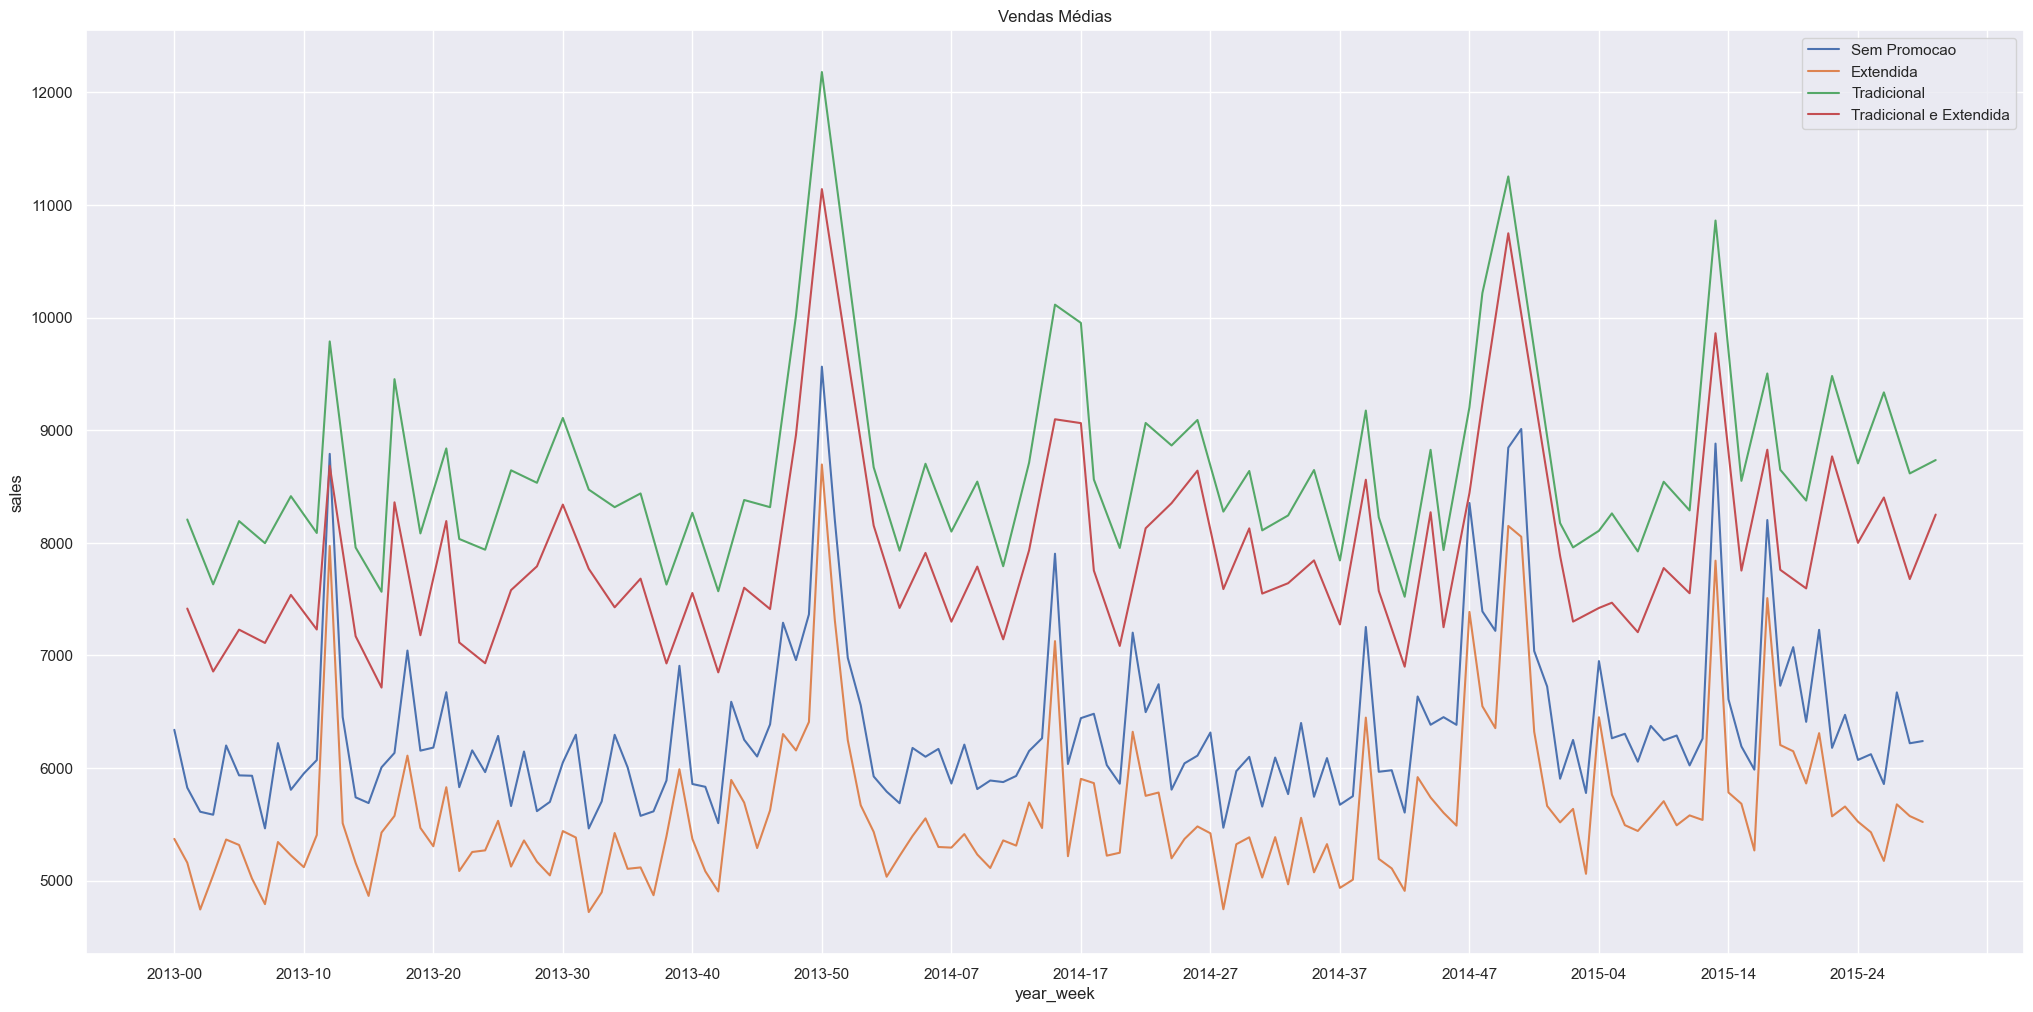

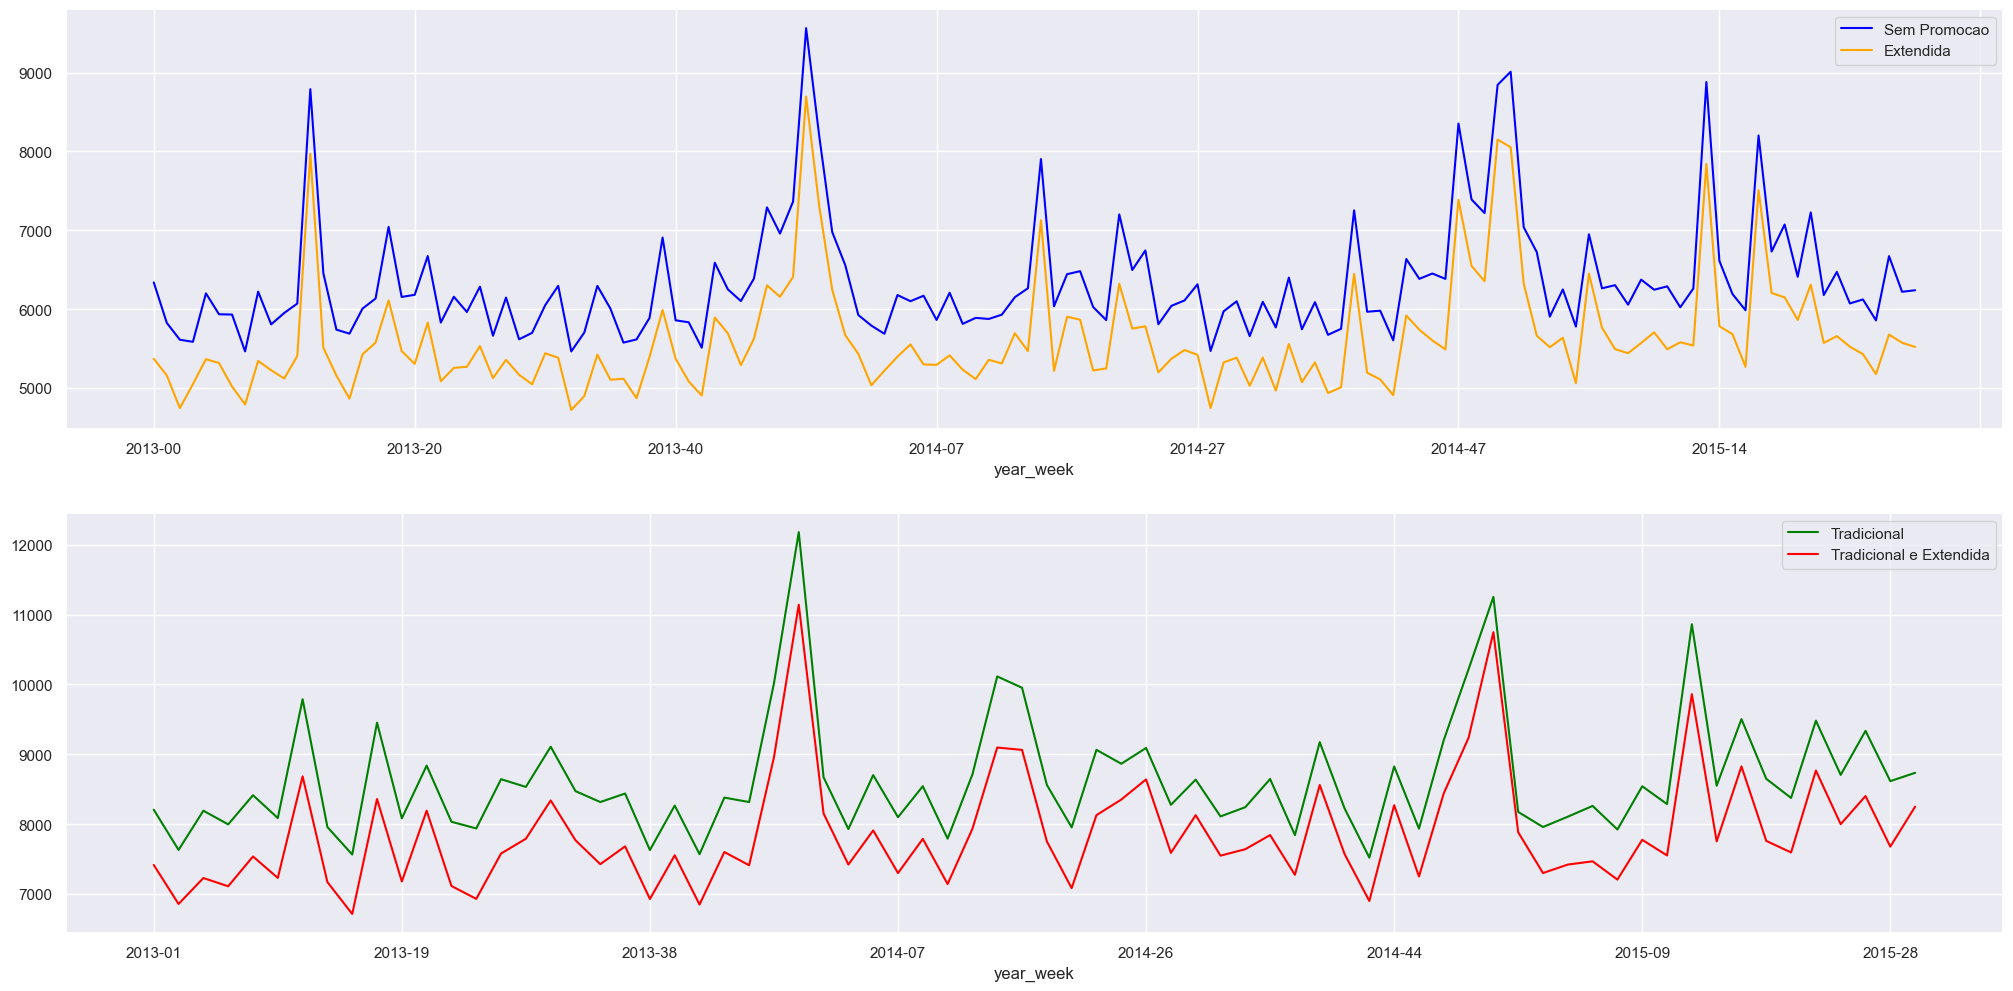

In [112]:
print('soma')
display(df4[['promo', 'promo2', 'sales']].groupby(['promo', 'promo2']).sum().reset_index())
print('média')
display(df4[['promo', 'promo2', 'sales']].groupby(['promo', 'promo2']).mean().reset_index())


aux1 = df4[['promo', 'promo2', 'sales', 'year_week']].groupby(['promo', 'promo2', 'year_week']).mean().reset_index()

aux1['both_promos'] = aux1['promo'].astype(str) + '-' + aux1['promo2'].astype(str)
ax = sns.lineplot(data=aux1, x="year_week", y="sales", hue="both_promos")
ax.xaxis.set_major_locator(ticker.MultipleLocator(10))

ax.legend(labels=['Sem Promocao', 'Extendida', 'Tradicional', 'Tradicional e Extendida'])
ax.set_title('Vendas Médias')
plt.show()



grid= plt.GridSpec(2,2)
# first two type promos plot
plt.subplot(grid[0,:])
aux2 = aux1[(aux1['promo'] == 0) & (aux1['promo2'] == 0)].set_index('year_week')['sales']
ax2 = aux2.plot(color='blue')

aux3 = aux1[(aux1['promo'] == 0) & (aux1['promo2'] == 1)].set_index('year_week')['sales']
aux3.plot(ax=ax2, color='orange')

ax2.legend(labels=['Sem Promocao', 'Extendida'])


# last two type promos plot
plt.subplot(grid[1,:])
aux4 = aux1[(aux1['promo'] == 1) & (aux1['promo2'] == 0)].set_index('year_week')['sales']
ax3 = aux4.plot(color='green')

aux5 = aux1[(aux1['promo'] == 1) & (aux1['promo2'] == 1)].set_index('year_week')['sales']
aux5.plot(ax=ax3, color='red')

ax3.legend(labels=['Tradicional', 'Tradicional e Extendida'])
plt.show()

### H6 - Lojas abertas durante o feriado de Natal deveriam vender mais.
**VERDADEIRA** Dentre os feriados, o de natal e pascoa vendem mais.

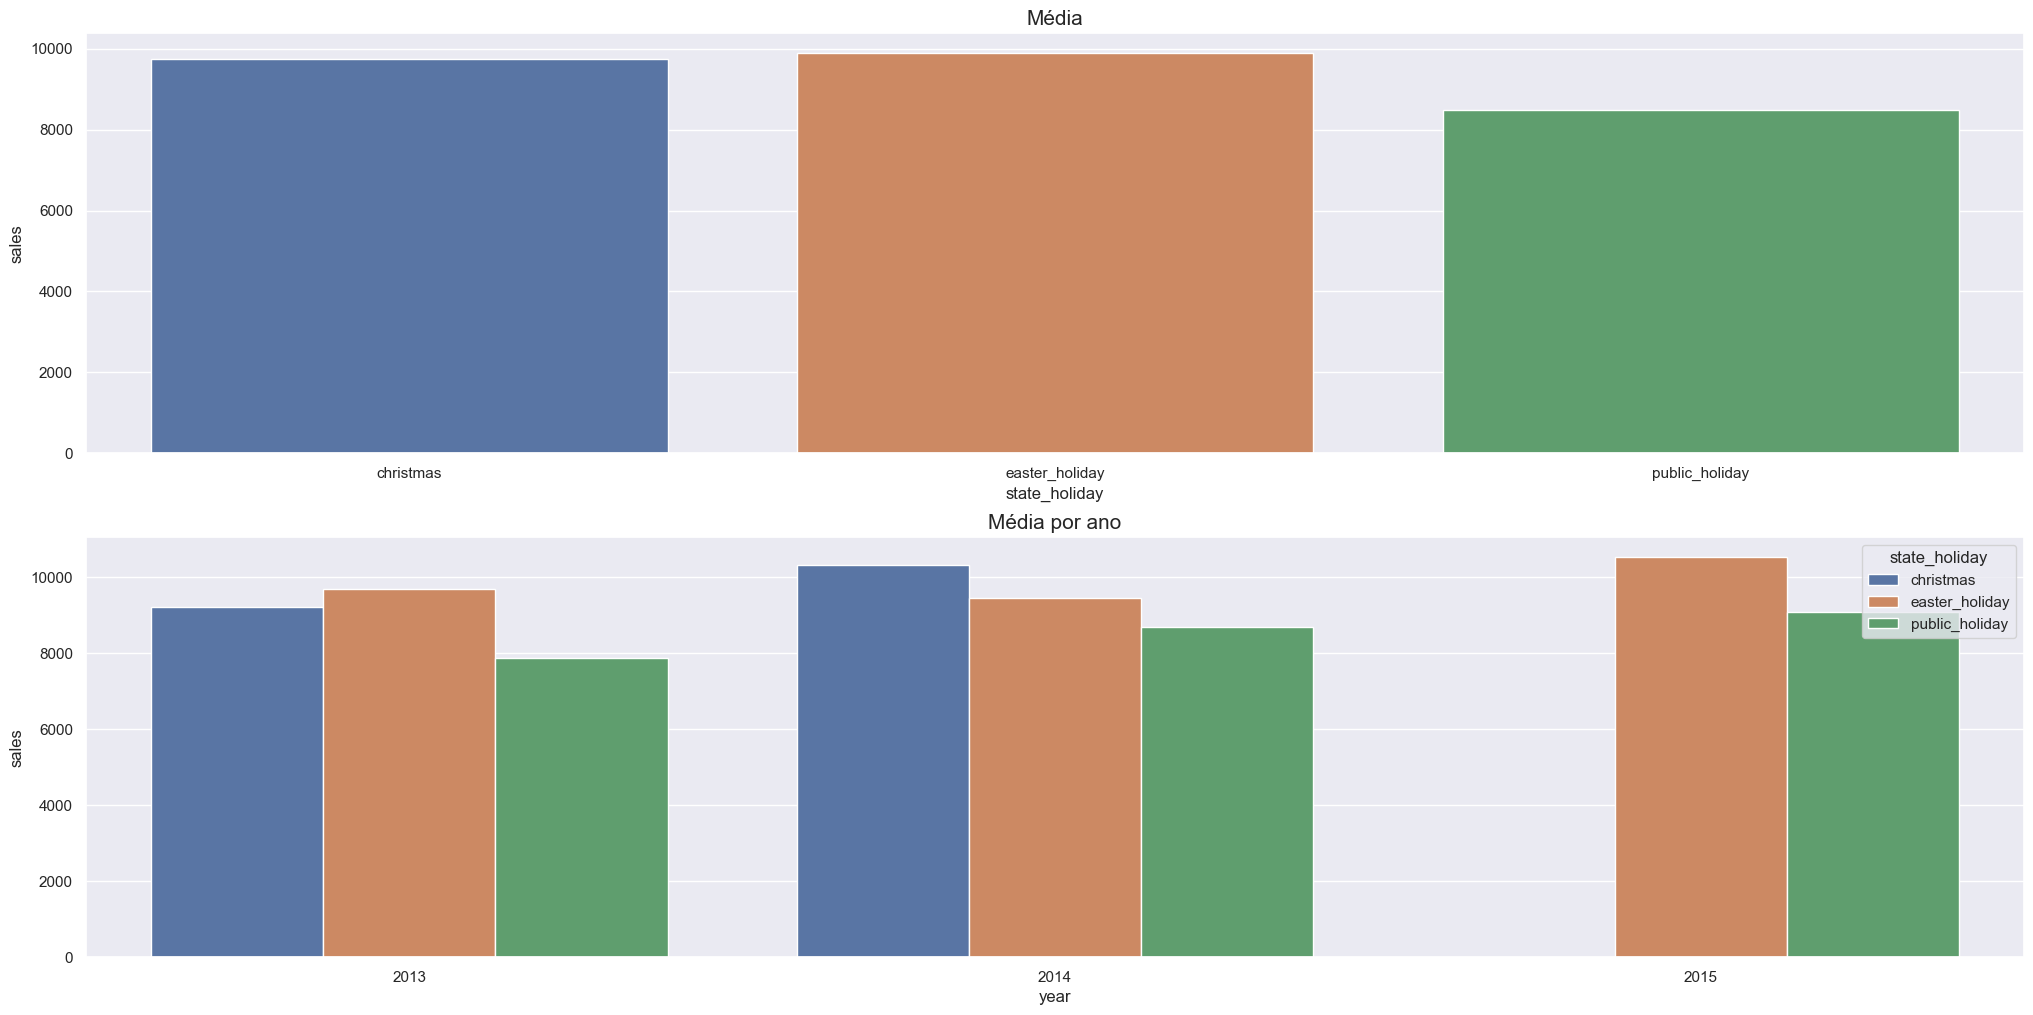

In [120]:
aux = df4[df4['state_holiday'] != 'regular_day']

plt.subplot(211)
aux1 = aux[['state_holiday', 'sales']].groupby( 'state_holiday' ).mean().reset_index()
ax1 = sns.barplot( x='state_holiday', y='sales', data=aux1 );
ax1.set_title('Média', fontsize=15);

plt.subplot(212)
aux2 = aux[['year', 'state_holiday', 'sales']].groupby( ['year', 'state_holiday'] ).mean().reset_index()
ax2 = sns.barplot( x='year', y='sales', hue='state_holiday', data=aux2 );
ax2.set_title('Média por ano', fontsize=15);



### H7 - Lojas deveriam vender mais ao longo dos anos.
**FALSA** Lojas vendem menos ao longo dos anos

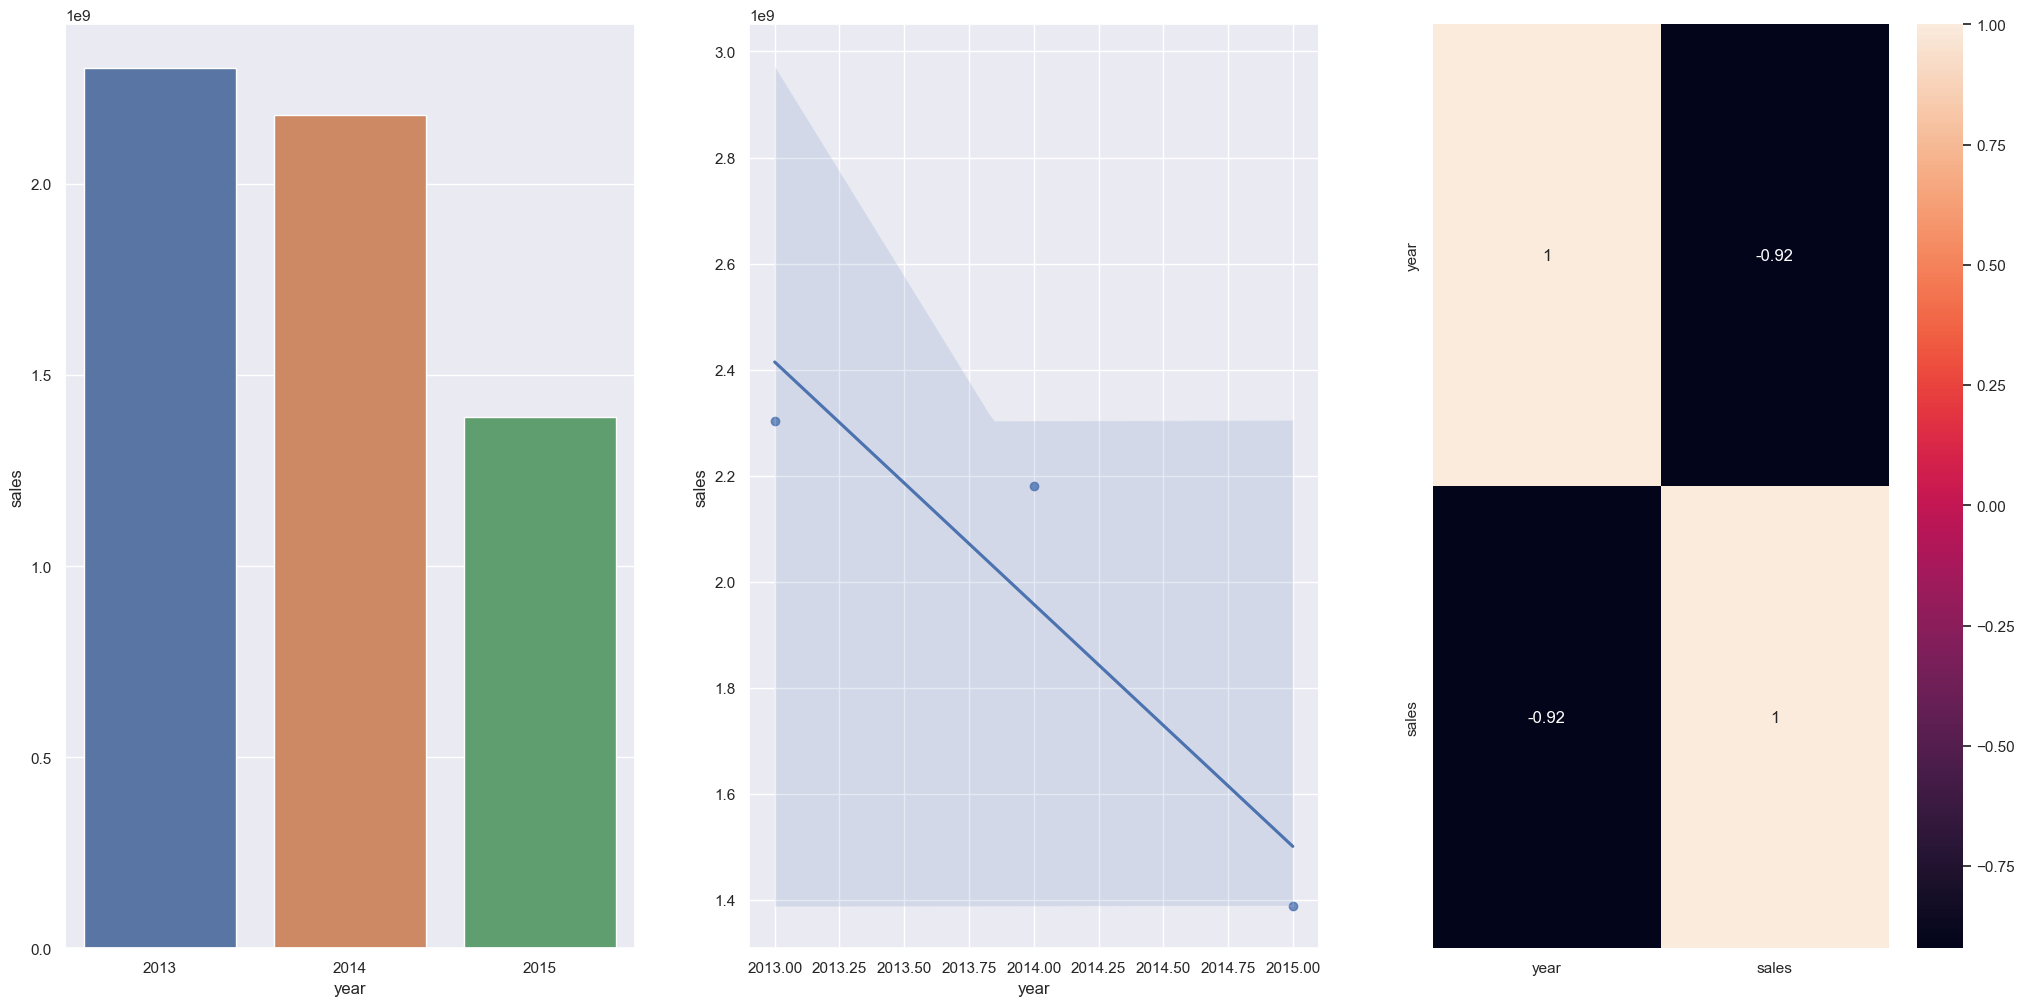

In [135]:

aux7 = df4[['year', 'sales']].groupby('year').sum().reset_index()

plt.subplot(131)
sns.barplot(x='year', y='sales', data=aux7);

plt.subplot(132)
sns.regplot(x='year', y='sales', data=aux7);

plt.subplot(133)
sns.heatmap(aux7.corr(method='pearson'), annot=True);

### H8 - Lojas deveriam vender mais no segundo semestre do ano.
**VERDADEIRA** Lojas vendem mais devido a dezembro, em média.

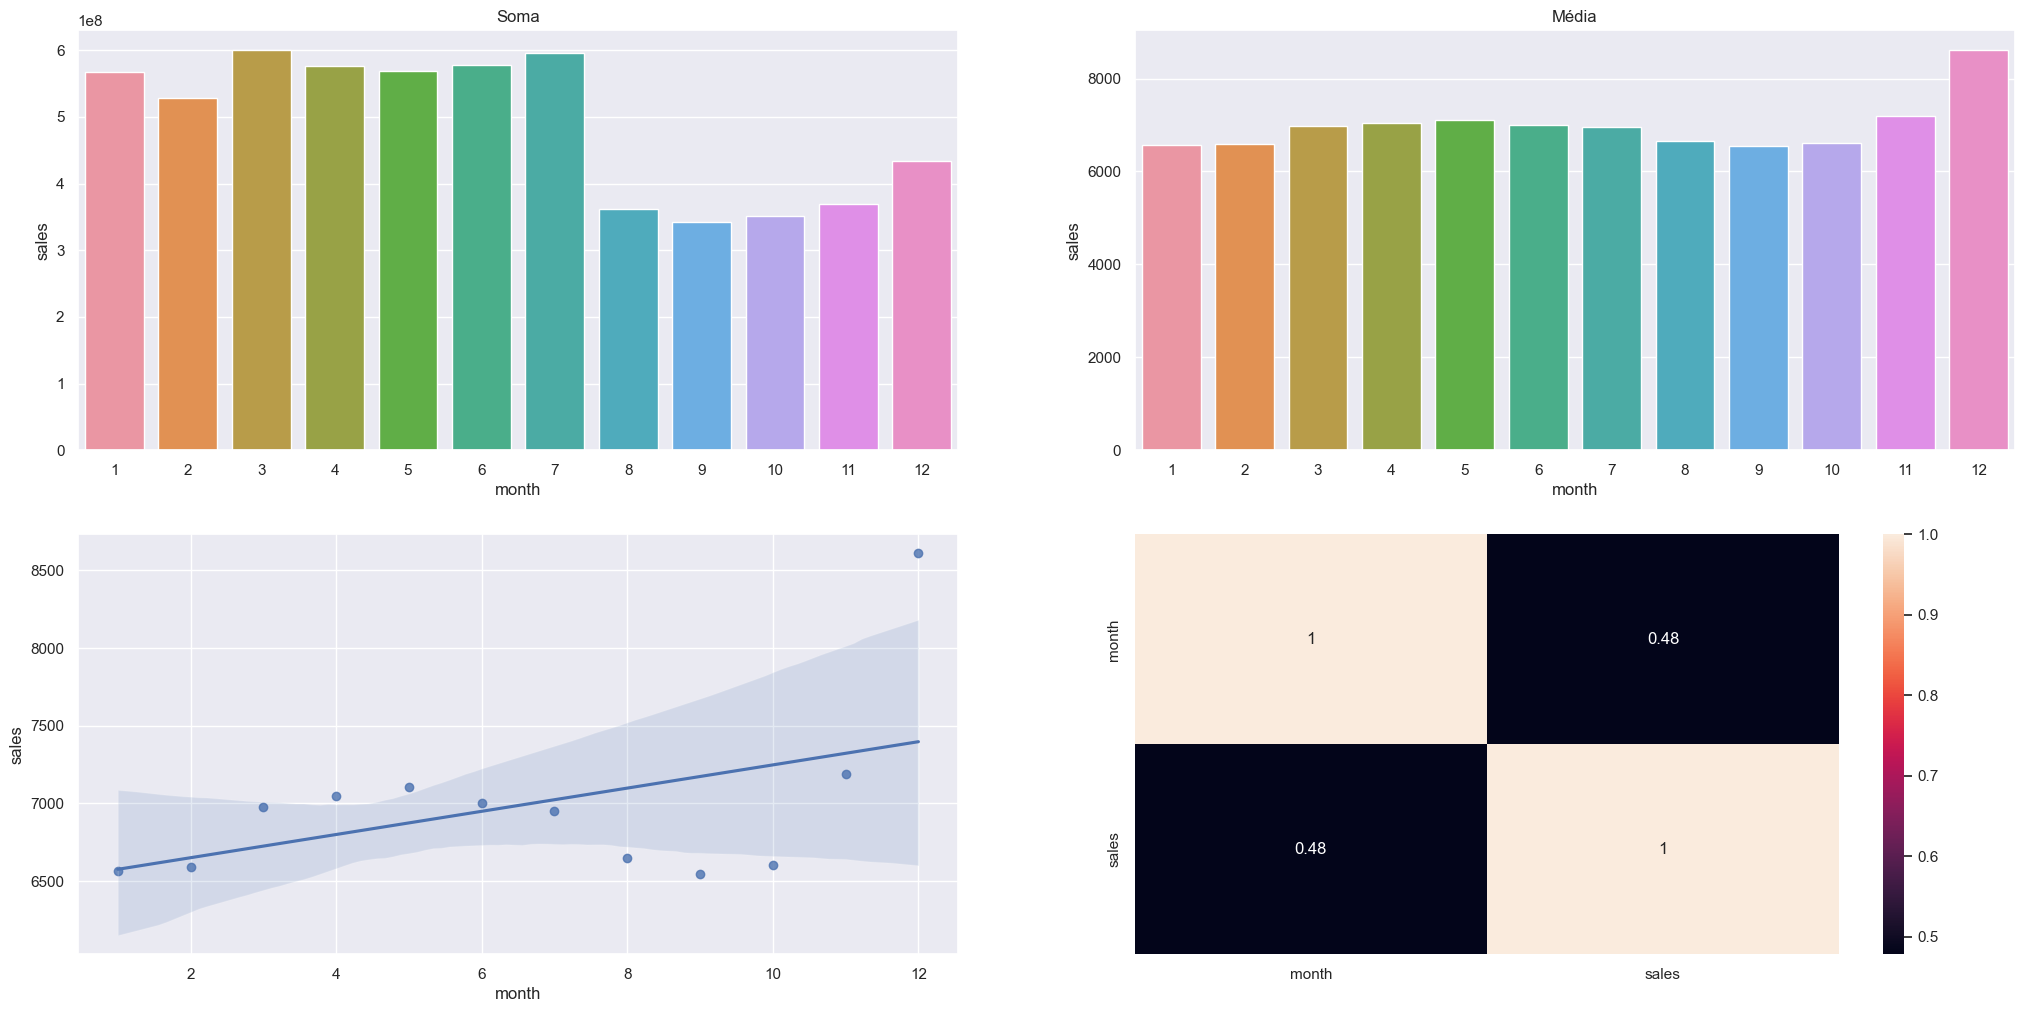

In [138]:
aux = df4[['month','sales']].groupby('month')
auxs = aux.sum().reset_index()
auxm = aux.mean().reset_index()

plt.subplot(221)
sns.barplot(x='month', y='sales', data=auxs).set_title('Soma')

plt.subplot(222)
sns.barplot(x='month', y='sales', data=auxm).set_title('Média')

plt.subplot(223)
sns.regplot(x='month', y='sales', data=auxm);
            
plt.subplot(224)
sns.heatmap(auxm.corr(method='pearson'), annot=True);

### H9 - Lojas deveriam vender mais depois do dia 10 de cada mês.
**VERDADEIRA** Lojas vendem mais depois do dia 10 de cada mes.

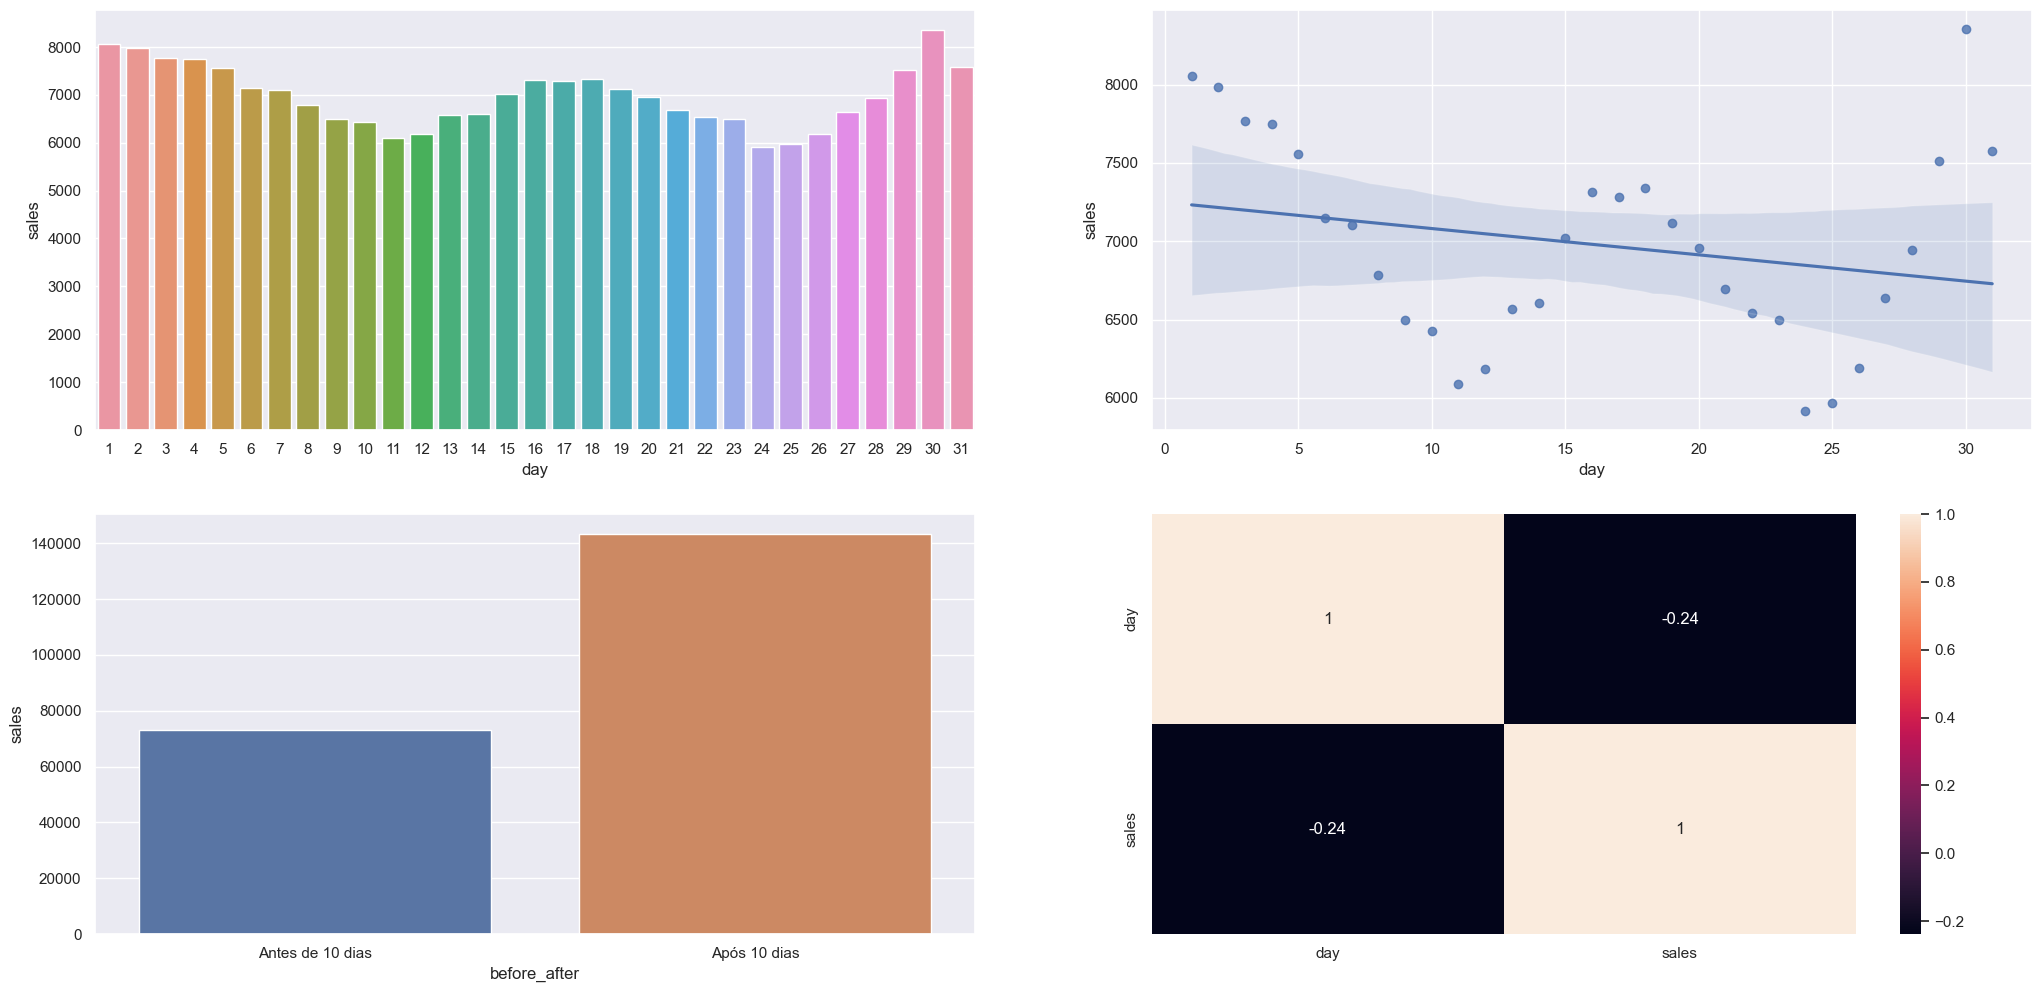

In [143]:
aux1 = df4[['day', 'sales']].groupby( 'day' ).mean().reset_index()

plt.subplot(221)
sns.barplot( x='day', y='sales', data=aux1 );

plt.subplot(222)
sns.regplot( x='day', y='sales', data=aux1 );

plt.subplot(224)
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

aux1['before_after'] = aux1['day'].apply( lambda x: 'Antes de 10 dias' if x <= 10 else 'Após 10 dias' )
aux2 =aux1[['before_after', 'sales']].groupby( 'before_after' ).sum().reset_index()

plt.subplot(223)
sns.barplot( x='before_after', y='sales', data=aux2 );

### H10 - Lojas deveriam vender menos aos finais de semana.
**VERDADEIRA** Lojas vendem menos nos final de semana

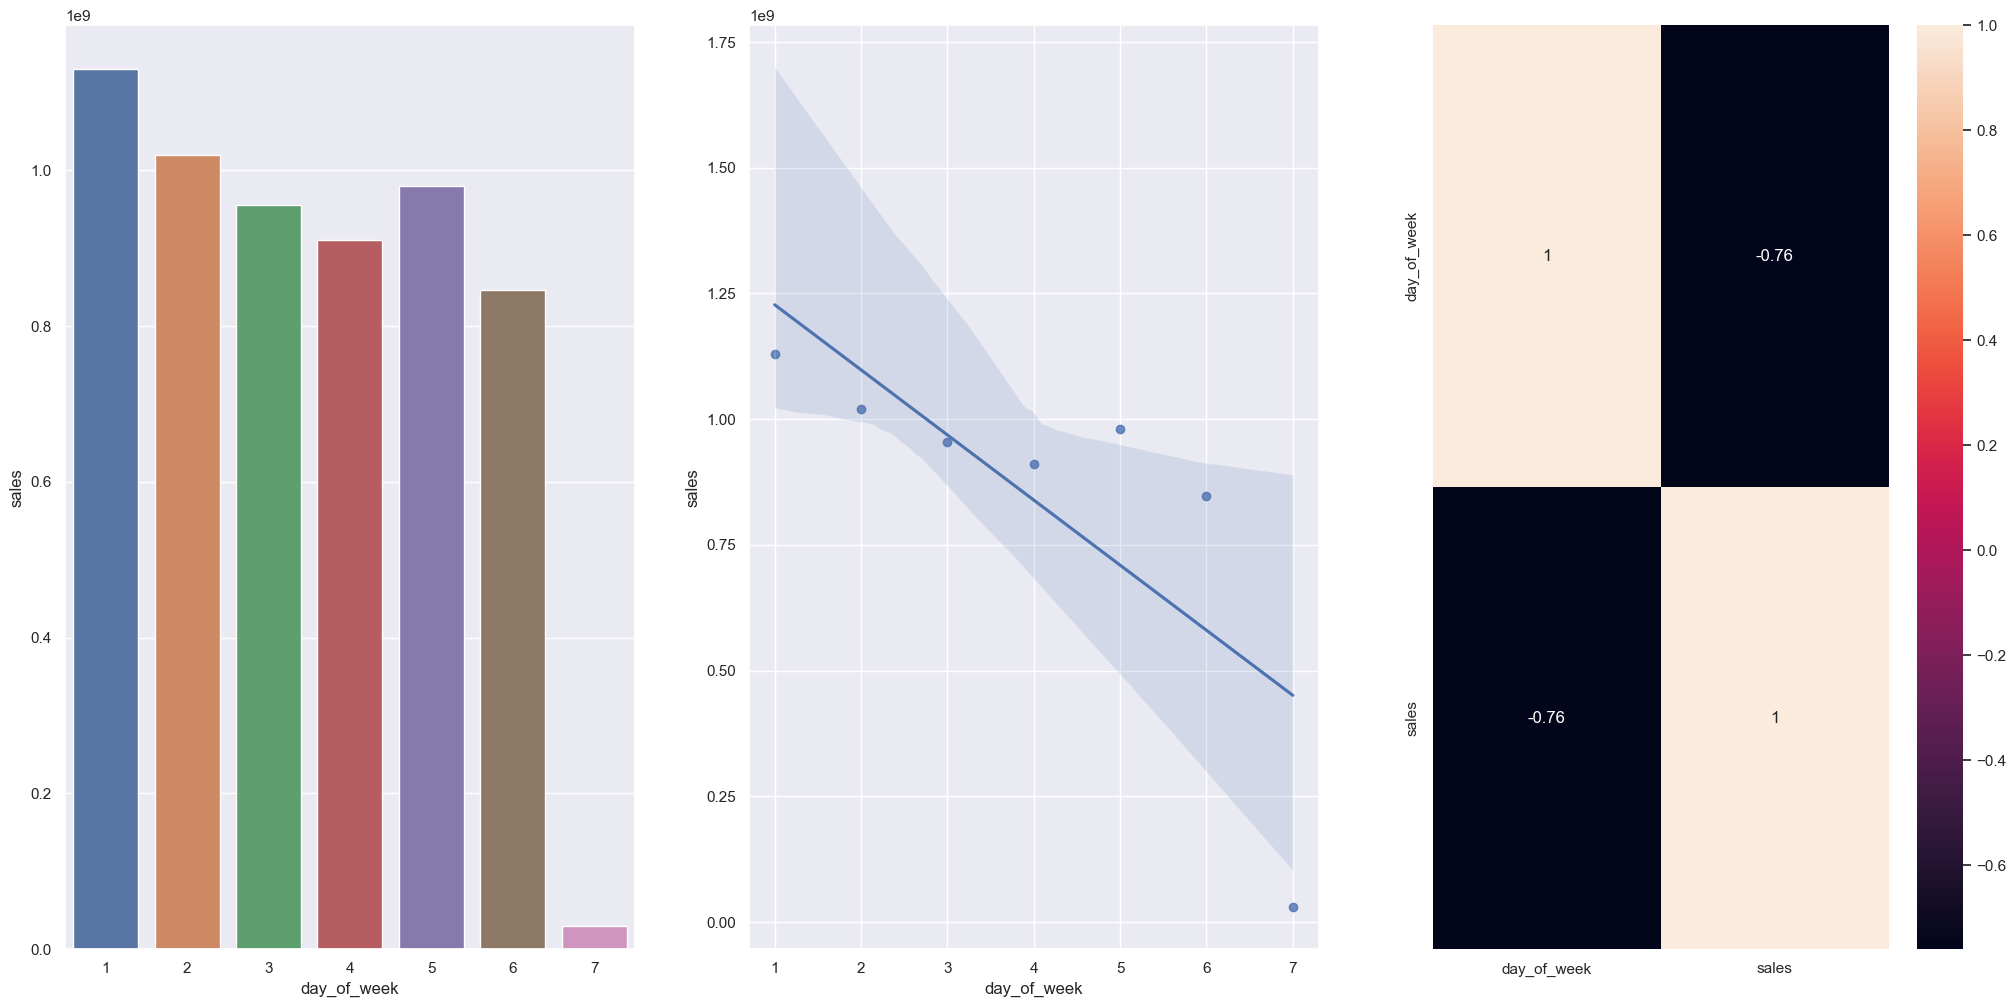

In [144]:
aux1 = df4[['day_of_week', 'sales']].groupby( 'day_of_week' ).sum().reset_index()

plt.subplot( 1, 3, 1 )
sns.barplot( x='day_of_week', y='sales', data=aux1 );

plt.subplot( 1, 3, 2 )
sns.regplot( x='day_of_week', y='sales', data=aux1 );

plt.subplot( 1, 3, 3 )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

### H11 - Lojas deveriam vender menos durante os feriados escolares.
**VERDADEIRA** Em média vende um pouco mais no feriado escolar.

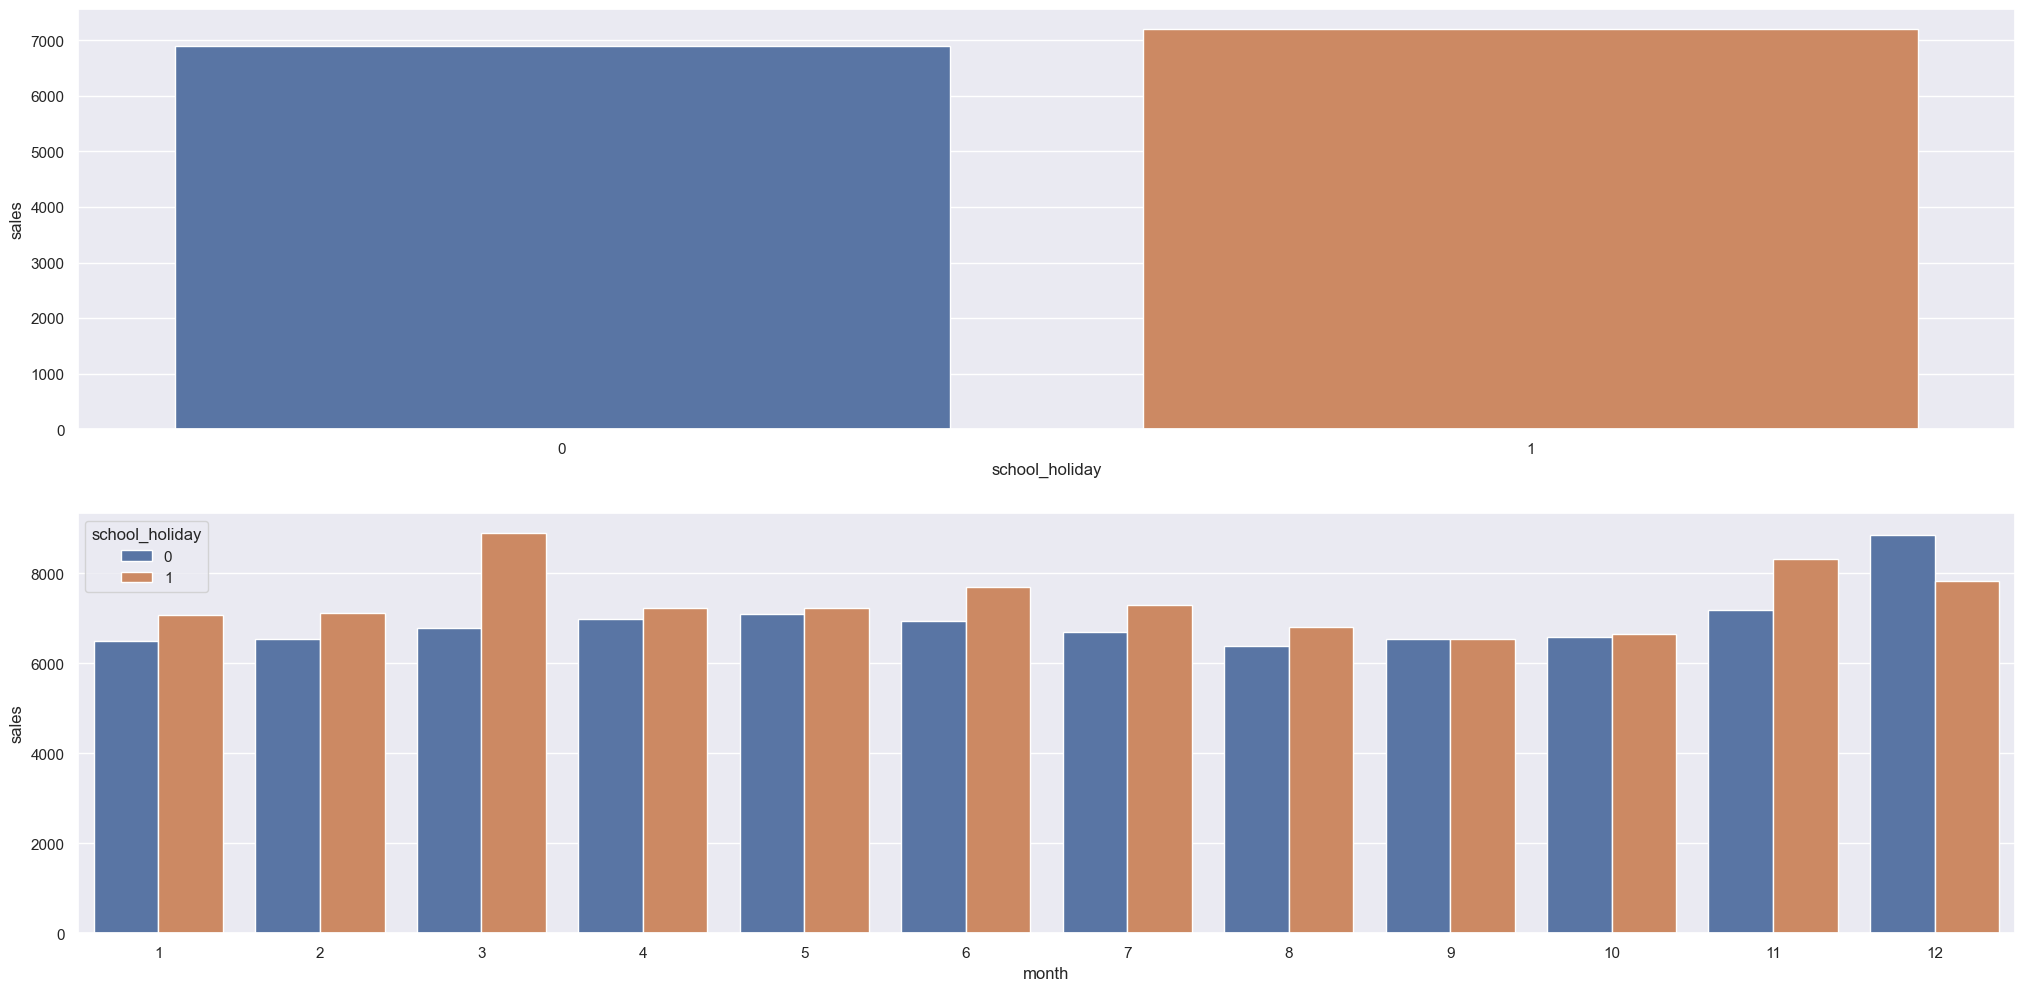

In [146]:
aux1 = df4[['school_holiday', 'sales']].groupby( 'school_holiday' ).mean().reset_index()
plt.subplot( 2, 1, 1 )
sns.barplot( x='school_holiday', y='sales', data=aux1 );

aux2 = df4[['month', 'school_holiday', 'sales']].groupby( ['month','school_holiday'] ).mean().reset_index()
plt.subplot( 2, 1, 2 )
sns.barplot( x='month', y='sales', hue='school_holiday', data=aux2 );

## 4.3. Analise Multivariada

### 4.3.1. Variáveis Numéricas

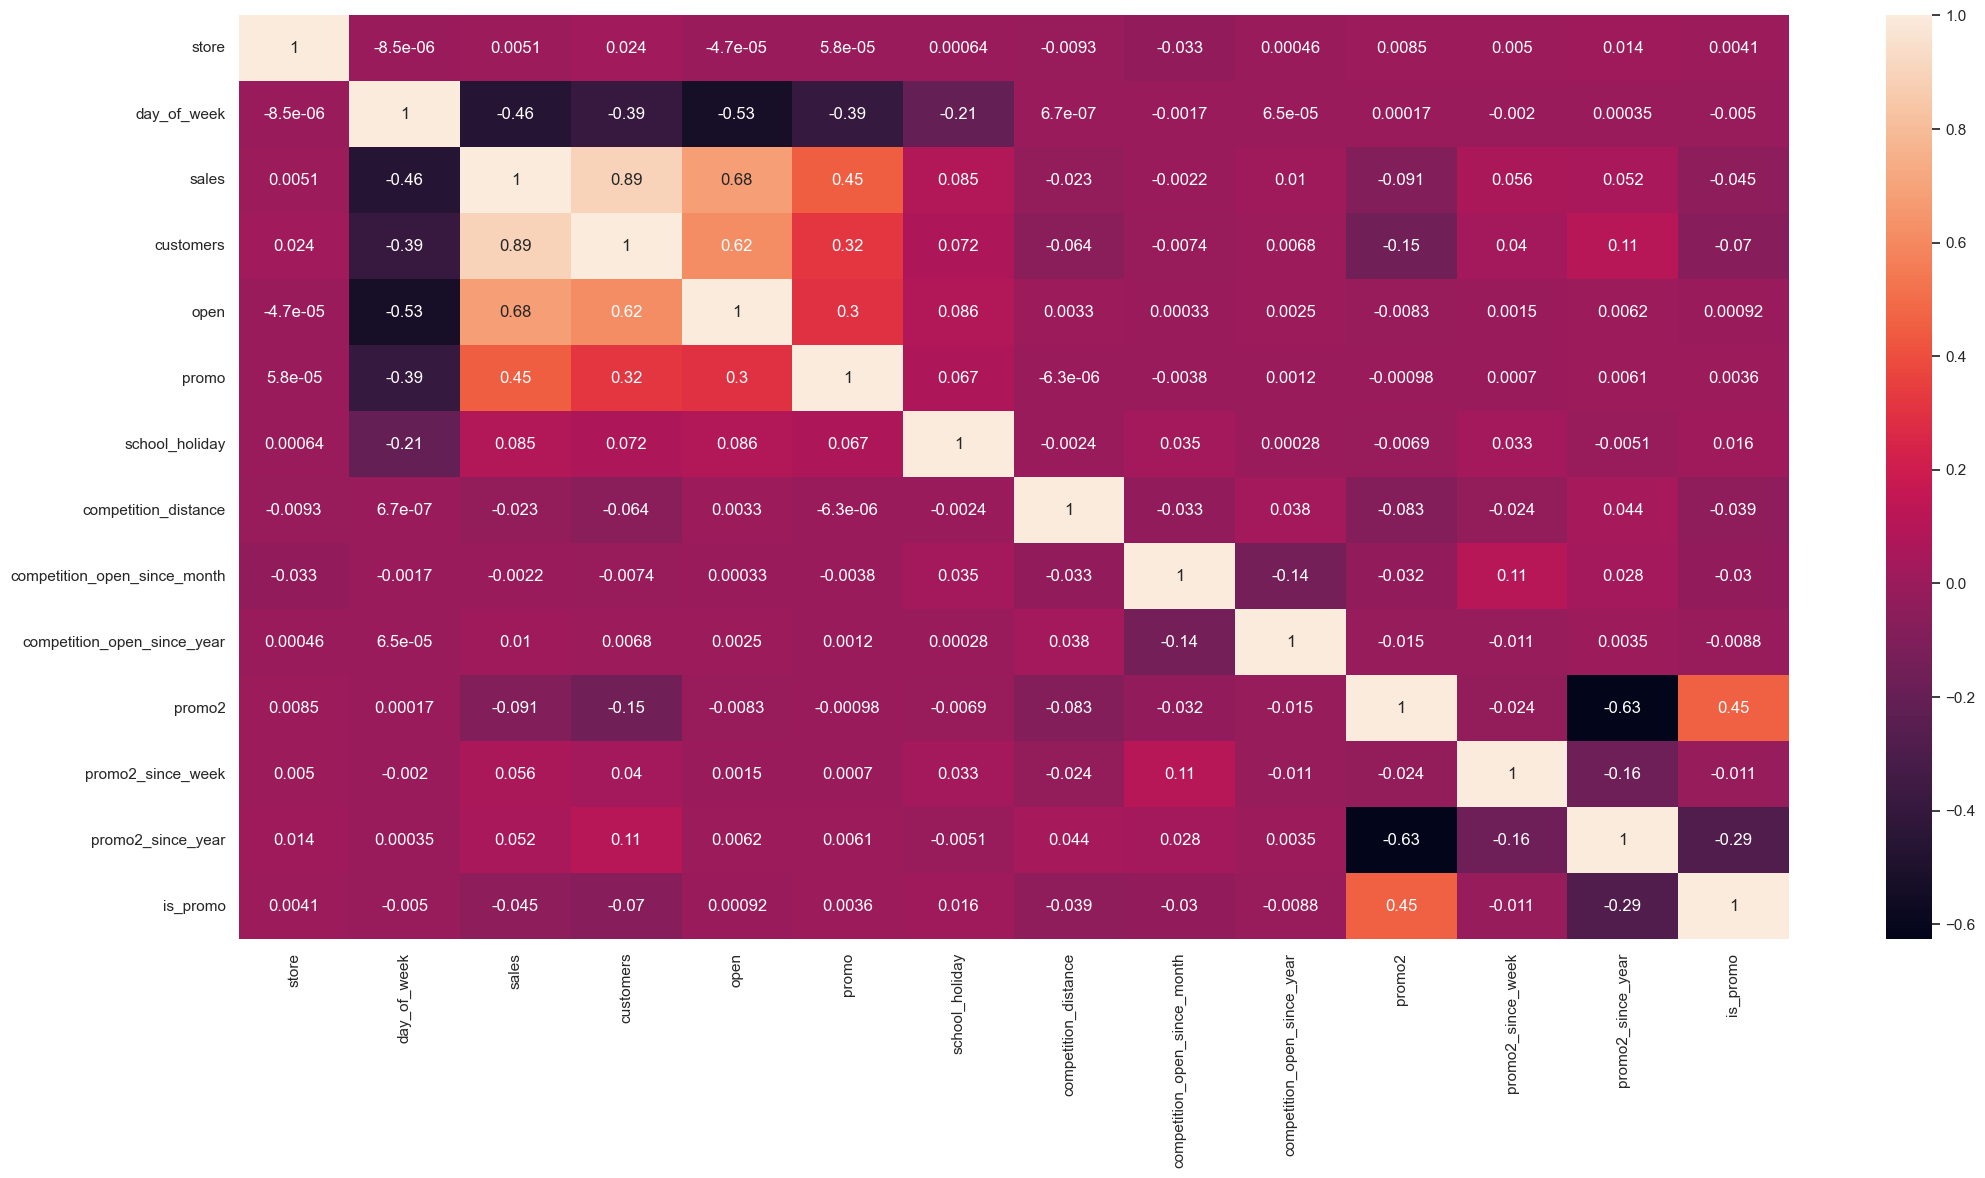

In [147]:
correlation = num_attributes.corr( method='pearson' )
sns.heatmap( correlation, annot=True );

### 4.3.2. Variáveis Categóricas

<AxesSubplot:>

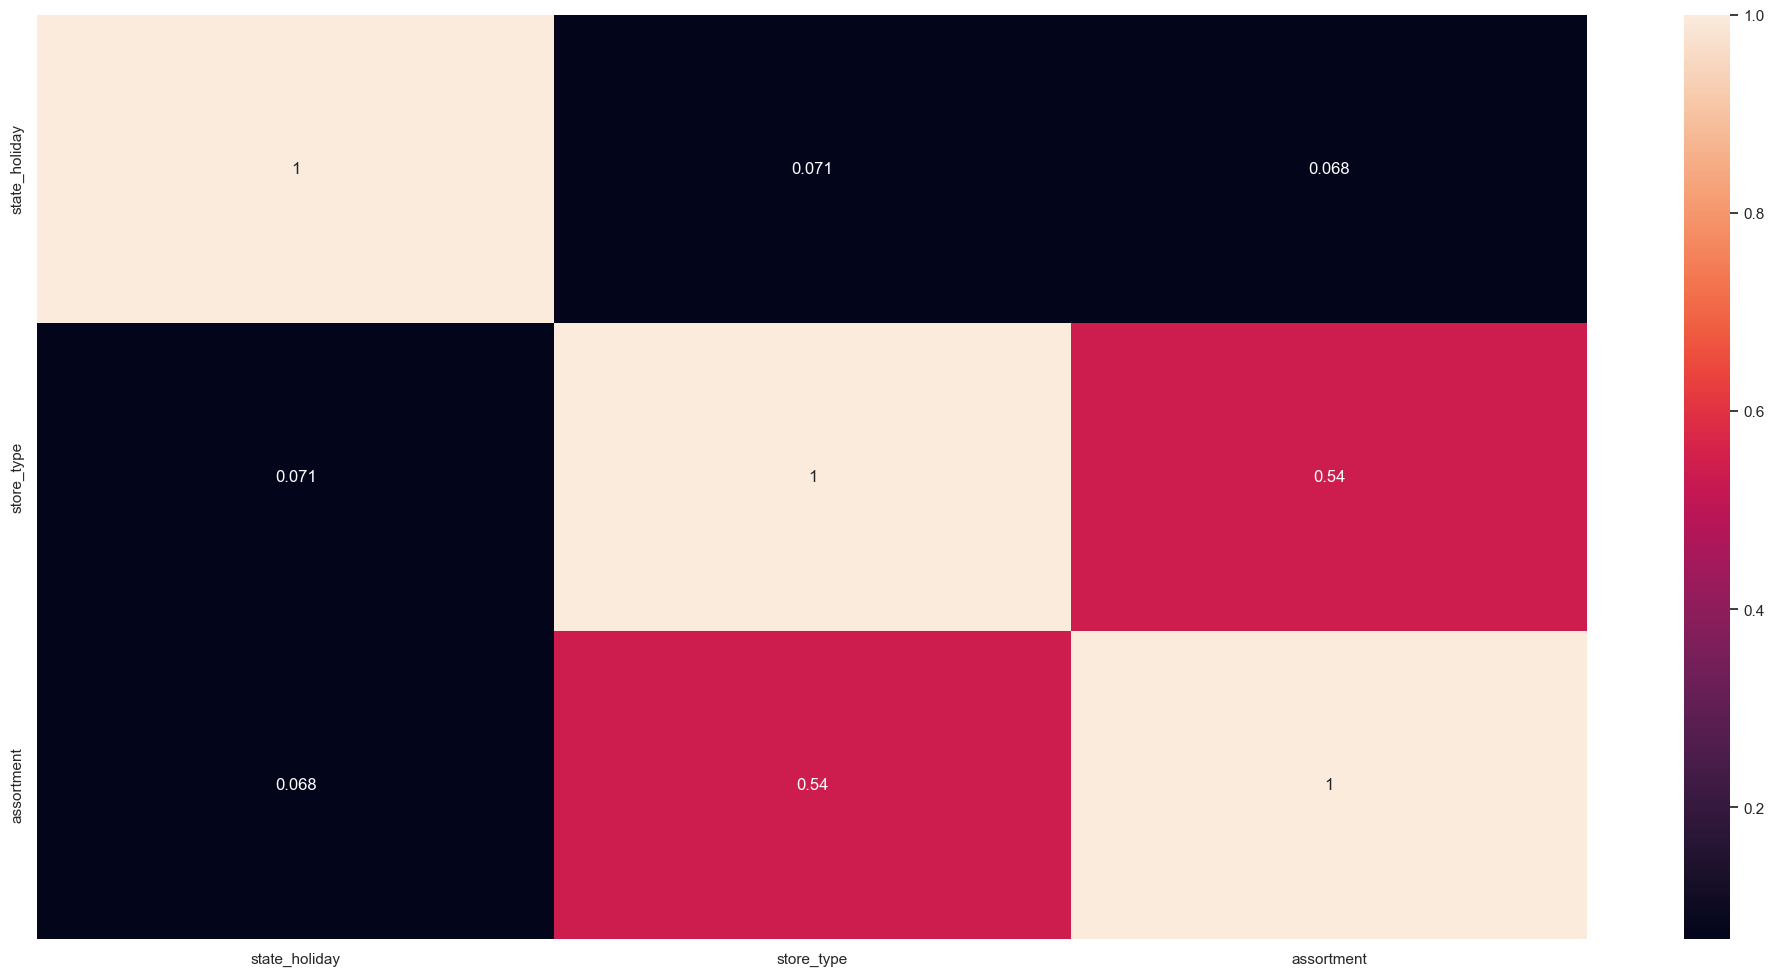

In [148]:
# only categorical data
a = df4.select_dtypes( include='object' )

# Calculate cramer V
a1 = cramer_v( a['state_holiday'], a['state_holiday'] )
a2 = cramer_v( a['state_holiday'], a['store_type'] )
a3 = cramer_v( a['state_holiday'], a['assortment'] )

a4 = cramer_v( a['store_type'], a['state_holiday'] )
a5 = cramer_v( a['store_type'], a['store_type'] )
a6 = cramer_v( a['store_type'], a['assortment'] )

a7 = cramer_v( a['assortment'], a['state_holiday'] )
a8 = cramer_v( a['assortment'], a['store_type'] )
a9 = cramer_v( a['assortment'], a['assortment'] )

# Final dataset
d = pd.DataFrame( {'state_holiday': [a1, a2, a3], 
               'store_type': [a4, a5, a6],
               'assortment': [a7, a8, a9]  })
d = d.set_index( d.columns )

sns.heatmap( d, annot=True )

# 5.0 - PREPARAÇÃO DOS DADOS

In [149]:
df5 = df4.copy()

## 5.1. Normalizacao

Analisando a plotagem dos gráficos das variáveis numericas percebemos que não há variáveis com shape de uma curva normal.

## 5.2. Rescaling

In [150]:
rs = RobustScaler()
mms = MinMaxScaler()

# competition distance
df5['competition_distance'] = rs.fit_transform( df5[['competition_distance']].values )
pickle.dump( rs, open( 'parameter/competition_distance_scaler.pkl', 'wb') )

# competition time month
df5['competition_time_month'] = rs.fit_transform( df5[['competition_time_month']].values )
pickle.dump( rs, open( 'parameter/competition_time_month_scaler.pkl', 'wb') )

# promo time week
df5['promo_time_week'] = mms.fit_transform( df5[['promo_time_week']].values )
pickle.dump( mms, open( 'parameter/promo_time_week_scaler.pkl', 'wb') )

# year
df5['year'] = mms.fit_transform( df5[['year']].values )
pickle.dump( mms, open( 'parameter/year_scaler.pkl', 'wb') )

## 5.3. Transformacao

### 5.3.1. Encoding

In [151]:
df5 = pd.get_dummies( df5, prefix=['state_holiday'], columns=['state_holiday'] )


le = LabelEncoder()
df5['store_type'] = le.fit_transform( df5['store_type'] )
pickle.dump( le, open( 'parameter/store_type_scaler.pkl', 'wb') )


assortment_dict = {'basic': 1,  'extra': 2, 'extended': 3}
df5['assortment'] = df5['assortment'].map( assortment_dict )

### 5.3.2. Transformação da variável reposta.

In [152]:
df5['sales'] = np.log1p( df5['sales'] )

<AxesSubplot:xlabel='sales', ylabel='Density'>

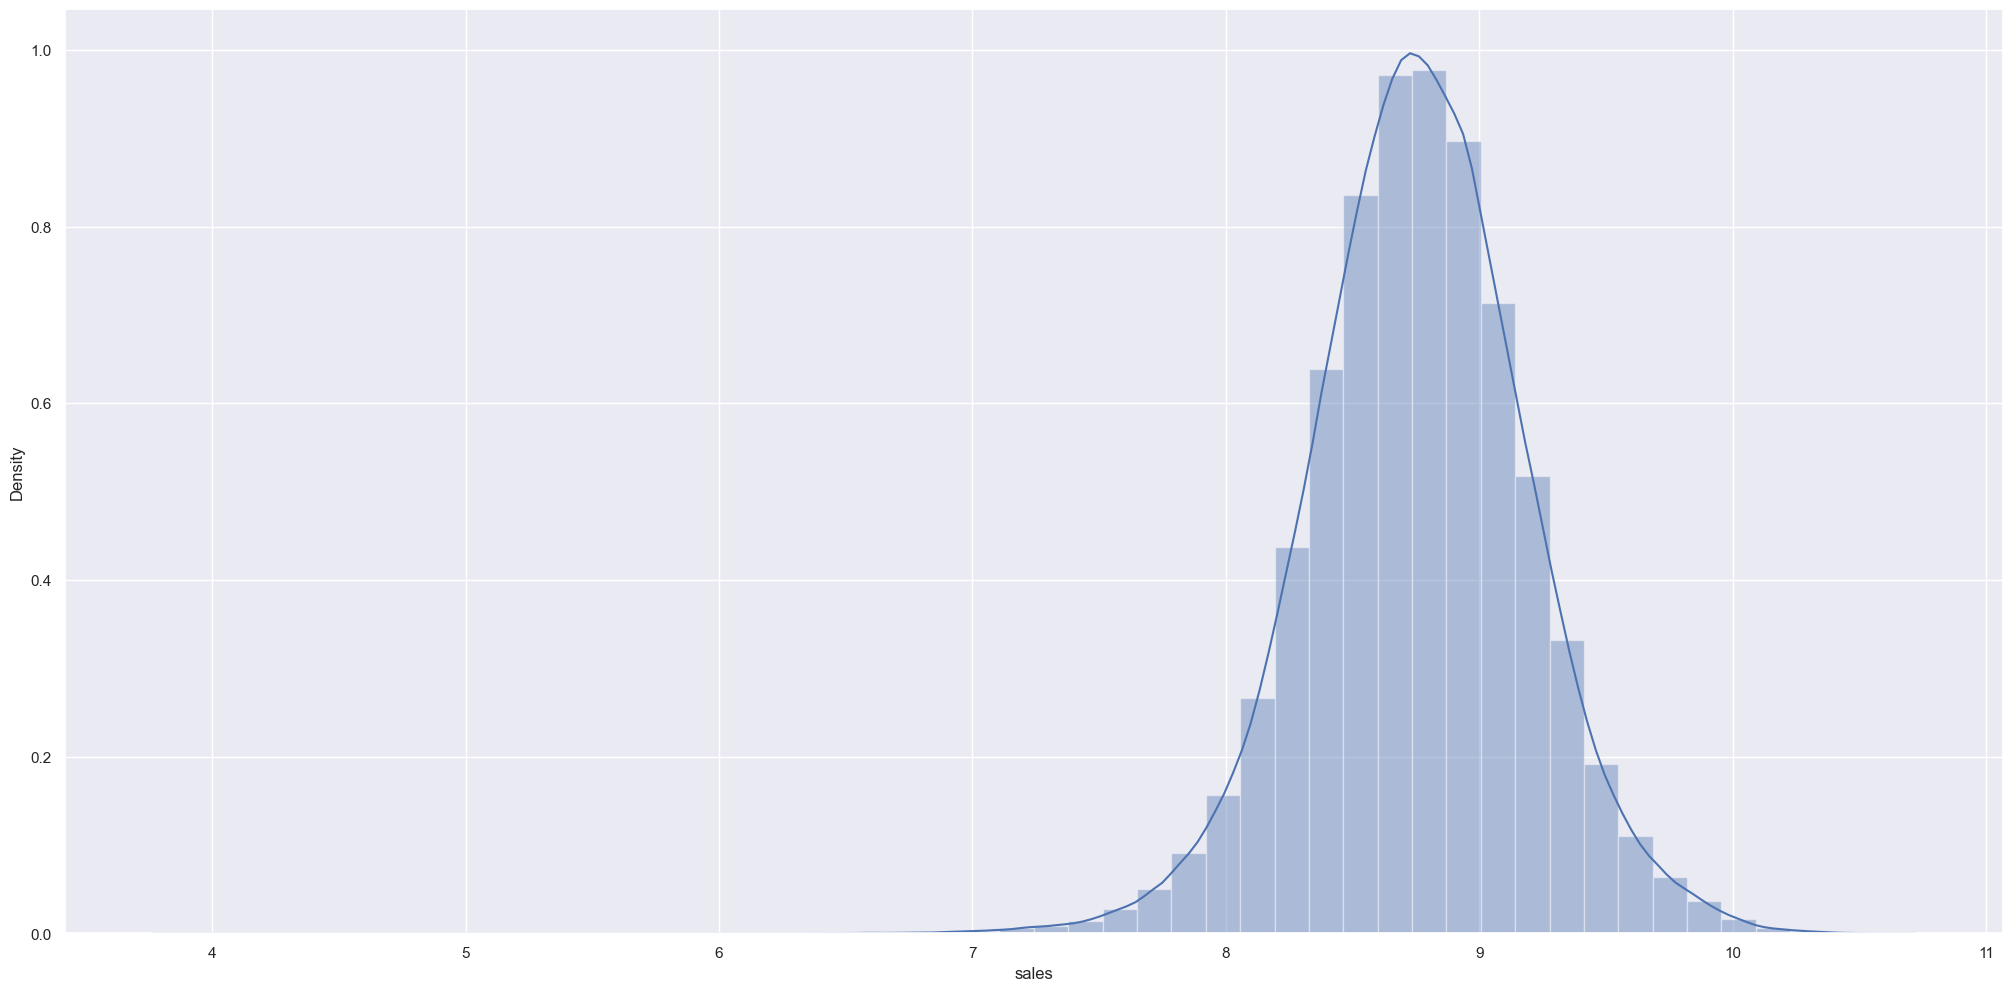

In [153]:
sns.distplot(df5['sales'])

### 5.3.3. Transformação baseada na natureza das variáveis

In [154]:
# day of week
df5['day_of_week_sin'] = df5['day_of_week'].apply( lambda x: np.sin( x * ( 2. * np.pi/7 ) ) ) # semanal
df5['day_of_week_cos'] = df5['day_of_week'].apply( lambda x: np.cos( x * ( 2. * np.pi/7 ) ) )

# month
df5['month_sin'] = df5['month'].apply( lambda x: np.sin( x * ( 2. * np.pi/12 ) ) ) #mensal
df5['month_cos'] = df5['month'].apply( lambda x: np.cos( x * ( 2. * np.pi/12 ) ) )

# day 
df5['day_sin'] = df5['day'].apply( lambda x: np.sin( x * ( 2. * np.pi/30 ) ) ) #diária
df5['day_cos'] = df5['day'].apply( lambda x: np.cos( x * ( 2. * np.pi/30 ) ) )

# week of year
df5['week_of_year_sin'] = df5['week_of_year'].apply( lambda x: np.sin( x * ( 2. * np.pi/52 ) ) ) #semanal
df5['week_of_year_cos'] = df5['week_of_year'].apply( lambda x: np.cos( x * ( 2. * np.pi/52 ) ) )

In [155]:
df5.head()

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,state_holiday_christmas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day,day_of_week_sin,day_of_week_cos,month_sin,month_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos
0,1,5,2015-07-31,8.568646,1,1,2,1,-0.170968,9,2008,0,31,2015,0,1.0,7,31,31,2015-30,2008-09-01,0.918919,2015-07-27,0.287016,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
1,2,5,2015-07-31,8.710290,1,1,0,1,-0.283871,11,2007,1,13,2010,1,1.0,7,31,31,2015-30,2007-11-01,1.054054,2010-03-22,0.922551,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
2,3,5,2015-07-31,9.025816,1,1,0,1,1.903226,12,2006,1,14,2011,1,1.0,7,31,31,2015-30,2006-12-01,1.202703,2011-03-28,0.801822,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
3,4,5,2015-07-31,9.546527,1,1,2,3,-0.275806,9,2009,0,31,2015,0,1.0,7,31,31,2015-30,2009-09-01,0.743243,2015-07-27,0.287016,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
4,5,5,2015-07-31,8.481151,1,1,0,1,4.448387,4,2015,0,31,2015,0,1.0,7,31,31,2015-30,2015-04-01,-0.162162,2015-07-27,0.287016,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984


# 6.0  - SELEÇÃO DE FEATURES

In [156]:
df6 = df5.copy()

## 6.1 - Split do dataframe em treino e teste

In [157]:
#deletando variáveis originais que não serão usadas pois ja tem variaveis derivadas com mesmo significado.
cols_drop = ['week_of_year', 'day', 'month', 'day_of_week', 'promo_since', 'competition_since', 'year_week' ]
df6 = df6.drop( cols_drop, axis=1 )

In [158]:
df6[['store', 'date']].groupby('store').max().reset_index()['date'][0] - datetime.timedelta ( days = 6*7)

Timestamp('2015-06-19 00:00:00')

In [159]:
#split do df em treino e teste

#vou separar as ultima 6 semanas de venda e separar como teste e o depois desse tempo
# training dataset
X_train = df6[df6['date'] < '2015-06-19']
y_train = X_train['sales']

# test dataset
X_test = df6[df6['date'] >= '2015-06-19']
y_test = X_test['sales']

print( 'Training Min Date: {}'.format( X_train['date'].min() ) )
print( 'Training Max Date: {}'.format( X_train['date'].max() ) )

print( '\nTest Min Date: {}'.format( X_test['date'].min() ) )
print( 'Test Max Date: {}'.format( X_test['date'].max() ) )

Training Min Date: 2013-01-01 00:00:00
Training Max Date: 2015-06-18 00:00:00

Test Min Date: 2015-06-19 00:00:00
Test Max Date: 2015-07-31 00:00:00


## 6.2. Boruta para selecionar fetures

In [106]:
# passando dasdos de treino para boruta selecionar as melhores features.
X_train_n = X_train.drop( ['date', 'sales'], axis=1 ).values
y_train_n = y_train.values.ravel() #ravel coloca num vetor

# define RandomForestRegressor
rf = RandomForestRegressor( n_jobs=-1 ) #n_jobs -1 usa todos os core do pc pra fazer as árvores.

# define Boruta
boruta = BorutaPy( rf, n_estimators='auto', verbose=2, random_state=42 ).fit( X_train_n, y_train_n )

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	18
Tentative: 	0
Rejected: 	9


BorutaPy finished running.

Iteration: 	9 / 100
Confirmed: 	18
Tentative: 	0
Rejected: 	9


### 6.2.1. Melhores features selacionadas pelo boruta

In [160]:
cols_selected = boruta.support_.tolist() #support mostra o ranking de variaveis que foram mais relevantes.

# best features
X_train_fs = X_train.drop( ['date', 'sales'], axis=1 )
cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.to_list()

# not selected boruta
cols_not_selected_boruta = list( np.setdiff1d( X_train_fs.columns, cols_selected_boruta ) )

In [161]:
cols_selected_boruta

['store',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'competition_time_month',
 'promo_time_week',
 'day_of_week_sin',
 'day_of_week_cos',
 'month_cos',
 'day_sin',
 'day_cos',
 'week_of_year_cos']

In [164]:
cols_not_selected_boruta

['is_promo',
 'month_sin',
 'school_holiday',
 'state_holiday_christmas',
 'state_holiday_easter_holiday',
 'state_holiday_public_holiday',
 'state_holiday_regular_day',
 'week_of_year_sin',
 'year']

## 6.3. Seleção manual de features

In [165]:
#seleciono as variaveis que o boruta achou como relevante e as que eu achei como relevante baseado na análise (4.2)
cols_selected_boruta = [
    'store',
    'promo',
    'store_type',
    'assortment',
    'competition_distance',
    'competition_open_since_month',
    'competition_open_since_year',
    'promo2',
    'promo2_since_week',
    'promo2_since_year',
    'competition_time_month',
    'promo_time_week',
    'day_of_week_sin',
    'day_of_week_cos',
    'month_sin',
    'month_cos',
    'day_sin',
    'day_cos',
    'week_of_year_sin',
    'week_of_year_cos']

# columns to add
#adicionando as colunas que exclui 
feat_to_add = ['date', 'sales']

cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend( feat_to_add )

# 7.0 - MACHINE LEARNING

In [166]:
x_train = X_train[ cols_selected_boruta ]
x_test = X_test[ cols_selected_boruta ]

# Time Series Data Preparation
x_training = X_train[ cols_selected_boruta_full ]

## 7.1. Average Model

Baseline

In [167]:
aux1 = x_test.copy() #criando uma copia do dataset de teste
aux1['sales'] = y_test.copy()

# prediction
aux2 = aux1[['store', 'sales']].groupby('store').mean().reset_index().rename(columns={'sales': 'predictions'})
aux1 = pd.merge( aux1, aux2, how='left', on='store' )
yhat_baseline = aux1['predictions'] #salva as predições

# performance
baseline_result = ml_error( 'Average Model', np.expm1(y_test), np.expm1(yhat_baseline))
baseline_result

,Model Name,MAE,MAPE,RMSE
0,Average Model,1354.800353,0.2064,1835.135542


## 7.2. Linear Regression Model

In [168]:
# model
lr = LinearRegression().fit(x_train, y_train)

# prediction
yhat_lr = lr.predict(x_test)

# performance
lr_result = ml_error('Linear Regression', np.expm1(y_test), np.expm1(yhat_lr))
lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,1865.508533,0.292454,2671.455737


### 7.2.1. Linear Regression Model - Cross Validation


In [169]:
lr_result_cv = cross_validation( x_training, 5, 'Linear Regression', lr, verbose=False )
lr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2081.83 +/- 295.43,0.3 +/- 0.02,2954.51 +/- 467.88


## 7.3. Linear Regression Regularized Model - Lasso

In [170]:
# model
lrr = Lasso( alpha=0.001 ).fit( x_train, y_train )

# prediction
yhat_lrr = lrr.predict( x_test )

# performance
lrr_result = ml_error( 'Linear Regression - Lasso', np.expm1( y_test ), np.expm1( yhat_lrr ) )
lrr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression - Lasso,1868.179067,0.2879,2694.493111


### 7.3.1.  Lasso - Cross Validation

In [171]:
lrr_result_cv = cross_validation( x_training, 5, 'Lasso', lrr, verbose=True )
lrr_result_cv


KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1


,Model Name,MAE CV,MAPE CV,RMSE CV
0,Lasso,2089.08 +/- 326.82,0.3 +/- 0.01,2990.57 +/- 499.1


## 7.4. Random Forest Regressor


In [172]:
# model
rf = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42, verbose = True).fit(x_train, y_train)

# prediction
yhat_rf = rf.predict(x_test)

# performance
rf_result = ml_error('Random Forest Regressor', np.expm1(y_test), np.expm1(yhat_rf))
rf_result

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  3.2min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.5s finished


,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,679.598831,0.099913,1011.119437


### 7.4.1.  Random Forest Regressor - Cross Validation

In [173]:
rf_result_cv = cross_validation(x_training, 5, 'Random Forest Regressor', rf, verbose=True)
rf_result_cv


KFold Number: 5


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   54.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.4min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.3s finished



KFold Number: 4


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.9min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.4s finished



KFold Number: 3


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  3.1min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.6s finished



KFold Number: 2


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  4.4min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.7s finished



KFold Number: 1


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  3.4min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.6s finished


,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest Regressor,836.61 +/- 217.1,0.12 +/- 0.02,1254.3 +/- 316.17


## 7.5. XGBoost Regressor

In [178]:
# model
model_xgb = xgb.XGBRegressor().fit( x_train, y_train )

# prediction
yhat_xgb = model_xgb.predict( x_test )

# performance
xgb_result = ml_error('XGBoost Regressor', np.expm1(y_test), np.expm1(yhat_xgb))
xgb_result

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,868.958205,0.130309,1238.550843


### 7.5.1. XGBoost Regressor - Cross Validation

In [179]:
xgb_result_cv = cross_validation(x_training, 5, 'XGBoost Regressor', model_xgb, verbose=True)
xgb_result_cv


KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1


,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,1064.95 +/- 178.65,0.15 +/- 0.02,1519.92 +/- 242.12


## 7.6. Compare Model's Performance

### 7.6.1. Single Performance

In [180]:
modelling_result = pd.concat([baseline_result, lr_result, lrr_result, rf_result, xgb_result])
modelling_result.sort_values('RMSE')

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,679.598831,0.099913,1011.119437
0,XGBoost Regressor,868.958205,0.130309,1238.550843
0,Average Model,1354.800353,0.206400,1835.135542
0,Linear Regression,1865.508533,0.292454,2671.455737
0,Linear Regression - Lasso,1868.179067,0.287900,2694.493111


### 7.6.2. Real Performance - Cross Validation

In [181]:
modelling_result_cv = pd.concat([lr_result_cv, lrr_result_cv, rf_result_cv, xgb_result_cv])
modelling_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2081.83 +/- 295.43,0.3 +/- 0.02,2954.51 +/- 467.88
0,Lasso,2089.08 +/- 326.82,0.3 +/- 0.01,2990.57 +/- 499.1
0,Random Forest Regressor,836.61 +/- 217.1,0.12 +/- 0.02,1254.3 +/- 316.17
0,XGBoost Regressor,1064.95 +/- 178.65,0.15 +/- 0.02,1519.92 +/- 242.12


Apesar do modelo random forest ter a performance ligeiramente melhor ao XGBoost, continuarei com o XGBoost pois ao realizar o treino o modelo ficou muito grande, por esse motivo não considero que seja um bom custoXbeneficio. 

# 8.0 - HYPERPARAMETER FINE TUNING

## 8.1. Random Search

In [182]:
param = {
    'n_estimators': [1500, 1700, 2500, 3000, 3500],
    'eta': [0.01, 0.03],
    'max_depth': [3, 5, 9],
    'subsample': [0.1, 0.5, 0.7],
    'colsample_bytree': [0.3, 0.7, 0.9],
    'min_child_weight': [3, 8, 15]
        }

MAX_EVAL = 5

In [183]:
final_result = pd.DataFrame()

for i in range( MAX_EVAL ):
    # choose values for parameters randomly
    hp = { k: random.sample( v, 1 )[0] for k, v in param.items() }
    print( hp )
    
    # model
    model_xgb = xgb.XGBRegressor( objective='reg:squarederror',
                                  n_estimators=hp['n_estimators'], 
                                  eta=hp['eta'], 
                                  max_depth=hp['max_depth'], 
                                  subsample=hp['subsample'],
                                  colsample_bytee=hp['colsample_bytree'],
                                  min_child_weight=hp['min_child_weight'] )

    # performance
    result = cross_validation( x_training, 5, 'XGBoost Regressor', model_xgb, verbose=True )
    final_result = pd.concat( [final_result, result] )
        
final_result

{'n_estimators': 3500, 'eta': 0.01, 'max_depth': 3, 'subsample': 0.5, 'colsample_bytree': 0.9, 'min_child_weight': 15}

KFold Number: 5
[13:26:43] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:576: 
Parameters: { "colsample_bytee" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.



KFold Number: 4
[13:37:51] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:576: 
Parameters: { "colsample_bytee" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an i


KFold Number: 3
[16:41:44] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:576: 
Parameters: { "colsample_bytee" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.



KFold Number: 2
[16:49:19] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:576: 
Parameters: { "colsample_bytee" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.



KFold Number: 1
[16:57:24] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xg

,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,1586.79 +/- 160.0,0.22 +/- 0.01,2289.7 +/- 208.51
0,XGBoost Regressor,954.06 +/- 158.25,0.13 +/- 0.02,1375.0 +/- 215.5
0,XGBoost Regressor,933.74 +/- 127.23,0.13 +/- 0.01,1329.68 +/- 172.01
0,XGBoost Regressor,1676.78 +/- 169.15,0.23 +/- 0.01,2413.04 +/- 224.54
0,XGBoost Regressor,804.61 +/- 125.1,0.11 +/- 0.01,1160.09 +/- 183.47


## 8.2. Modelo Final

In [184]:
param_tuned = {
    'n_estimators': 1500,
    'eta': 0.03,
    'max_depth': 9,
    'subsample': 0.5,
    'colsample_bytree': 0.3,
    'min_child_weight': 8 
        }

In [185]:
# model
model_xgb_tuned = xgb.XGBRegressor( objective='reg:squarederror',
                                    n_estimators=param_tuned['n_estimators'], 
                                    eta=param_tuned['eta'], 
                                    max_depth=param_tuned['max_depth'], 
                                    subsample=param_tuned['subsample'],
                                    colsample_bytee=param_tuned['colsample_bytree'],
                                    min_child_weight=param_tuned['min_child_weight'] ).fit( x_train, y_train )

# prediction
yhat_xgb_tuned = model_xgb_tuned.predict( x_test )

# performance
xgb_result_tuned = ml_error( 'XGBoost Regressor', np.expm1( y_test ), np.expm1( yhat_xgb_tuned ) )
xgb_result_tuned

[18:27:01] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:576: 
Parameters: { "colsample_bytee" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,635.119893,0.09238,930.139133


In [186]:
mpe = mean_percentage_error( np.expm1( y_test ), np.expm1( yhat_xgb_tuned ) )
mpe

0.0016348018537999508

# 9.0 - TRADUCAO E INTERPRETACAO DO ERRO

In [187]:
df9 = X_test[ cols_selected_boruta_full ]

# rescale
df9['sales'] = np.expm1( df9['sales'] )
df9['predictions'] = np.expm1( yhat_xgb_tuned )

## 9.1. Business Performance

In [188]:
# sum of predictions
df91 = df9[['store', 'predictions']].groupby( 'store' ).sum().reset_index()

# MAE and MAPE
df9_aux1 = df9[['store', 'sales', 'predictions']].groupby( 'store' ).apply( lambda x: mean_absolute_error( x['sales'], x['predictions'] ) ).reset_index().rename( columns={0:'MAE'})
df9_aux2 = df9[['store', 'sales', 'predictions']].groupby( 'store' ).apply( lambda x: mean_absolute_percentage_error( x['sales'], x['predictions'] ) ).reset_index().rename( columns={0:'MAPE'})

# Merge
df9_aux3 = pd.merge( df9_aux1, df9_aux2, how='inner', on='store' )
df92 = pd.merge( df91, df9_aux3, how='inner', on='store' )

# Scenarios
df92['worst_scenario'] = df92['predictions'] - df92['MAE']
df92['best_scenario'] = df92['predictions'] + df92['MAE']

# order columns
df92 = df92[['store', 'predictions', 'worst_scenario', 'best_scenario', 'MAE', 'MAPE']]

In [189]:
df92.sort_values( 'MAPE', ascending=False ).head()

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
291,292,104582.81250,101252.462145,107913.162855,3330.350355,0.554214
908,909,232751.62500,225090.438986,240412.811014,7661.186014,0.513651
875,876,205953.12500,202059.084271,209847.165729,3894.040729,0.302213
594,595,366597.00000,362201.973329,370992.026671,4395.026671,0.297566
721,722,347086.71875,345254.537281,348918.900219,1832.181469,0.247925


<AxesSubplot:xlabel='store', ylabel='MAPE'>

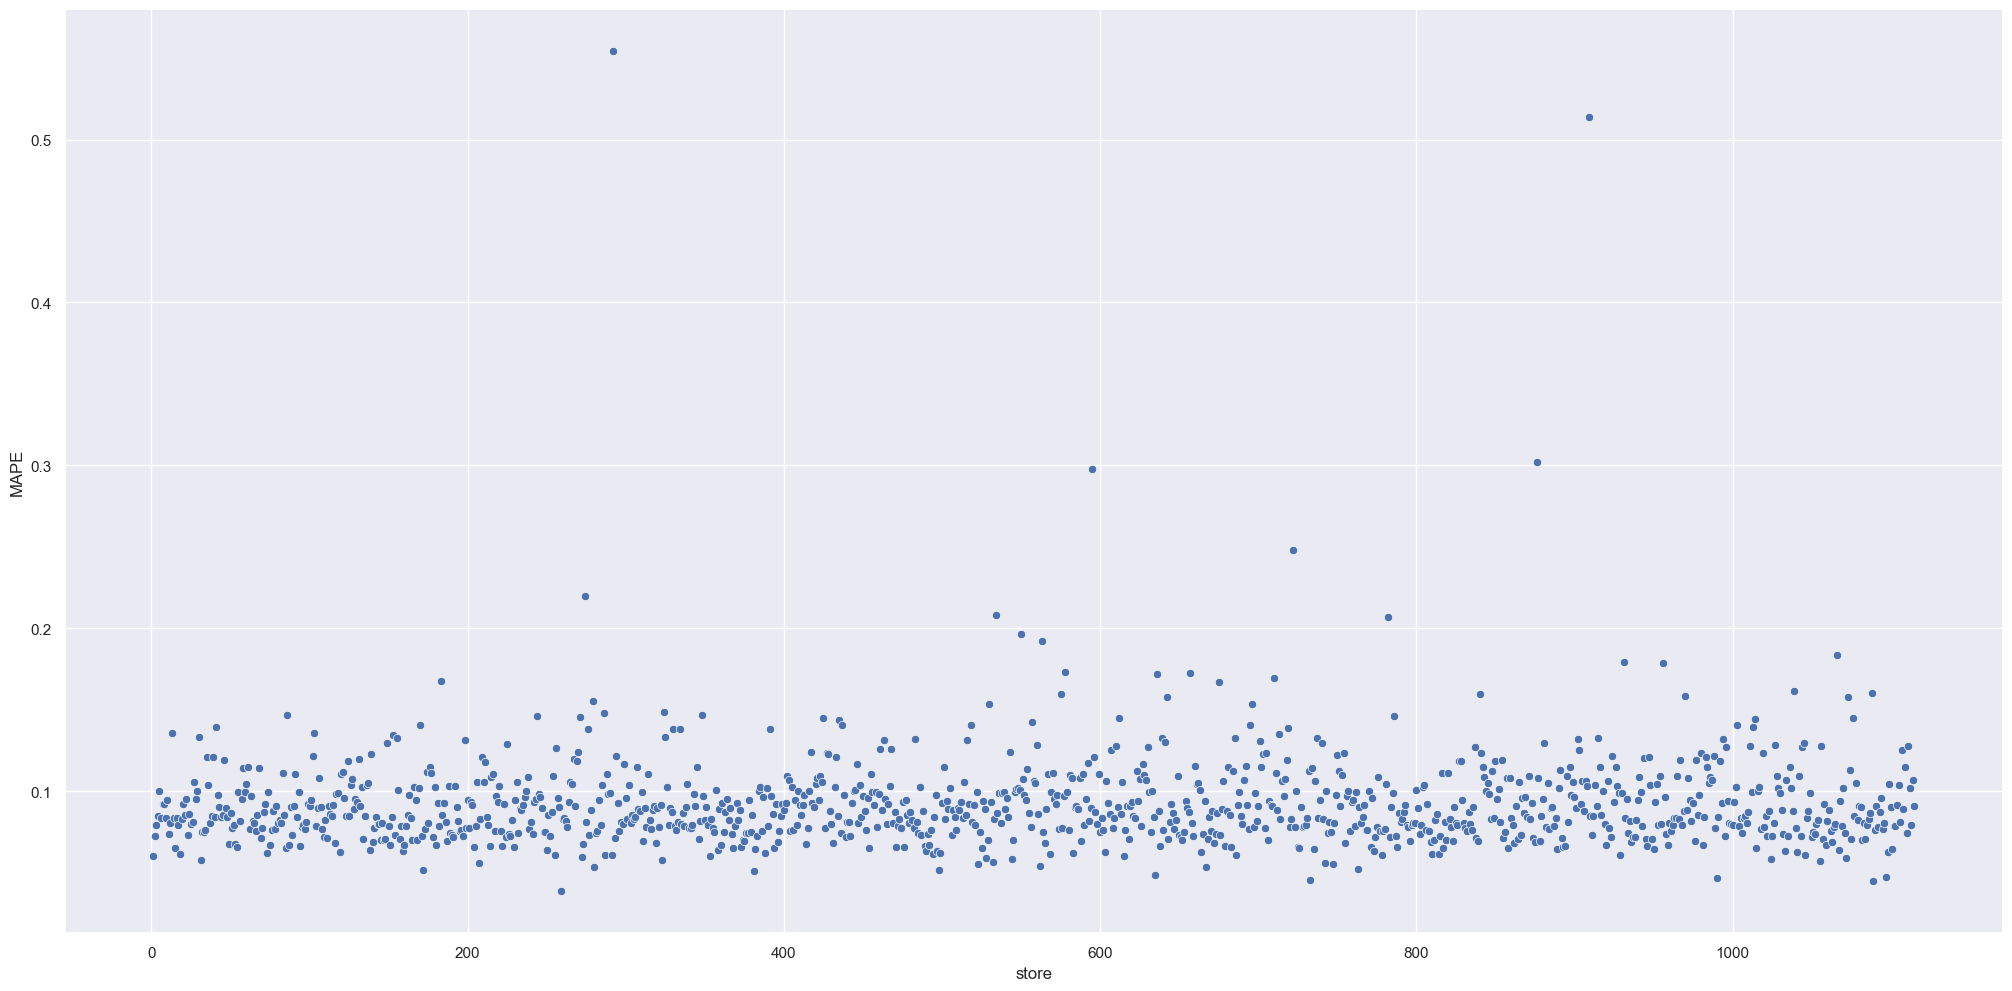

In [190]:
sns.scatterplot( x='store', y='MAPE', data=df92 )
#tenho lojas com 50% de erro, são lojas mais dificeis pra acertar. exemplo a 292.

## 9.2. Total Performance

In [191]:
df93 = df92[['predictions', 'worst_scenario', 'best_scenario']].apply( lambda x: np.sum( x ), axis=0 ).reset_index().rename( columns={'index': 'Scenario', 0:'Values'} )
df93['Values'] = df93['Values'].map( 'R${:,.2f}'.format )
df93

,Scenario,Values
0,predictions,"R$284,031,872.00"
1,worst_scenario,"R$283,319,667.11"
2,best_scenario,"R$284,744,059.34"


## 9.3. Machine Learning Performance

In [192]:
df9['error'] = df9['sales'] - df9['predictions']
df9['error_rate'] = df9['predictions'] / df9['sales']

<AxesSubplot:xlabel='predictions', ylabel='error'>

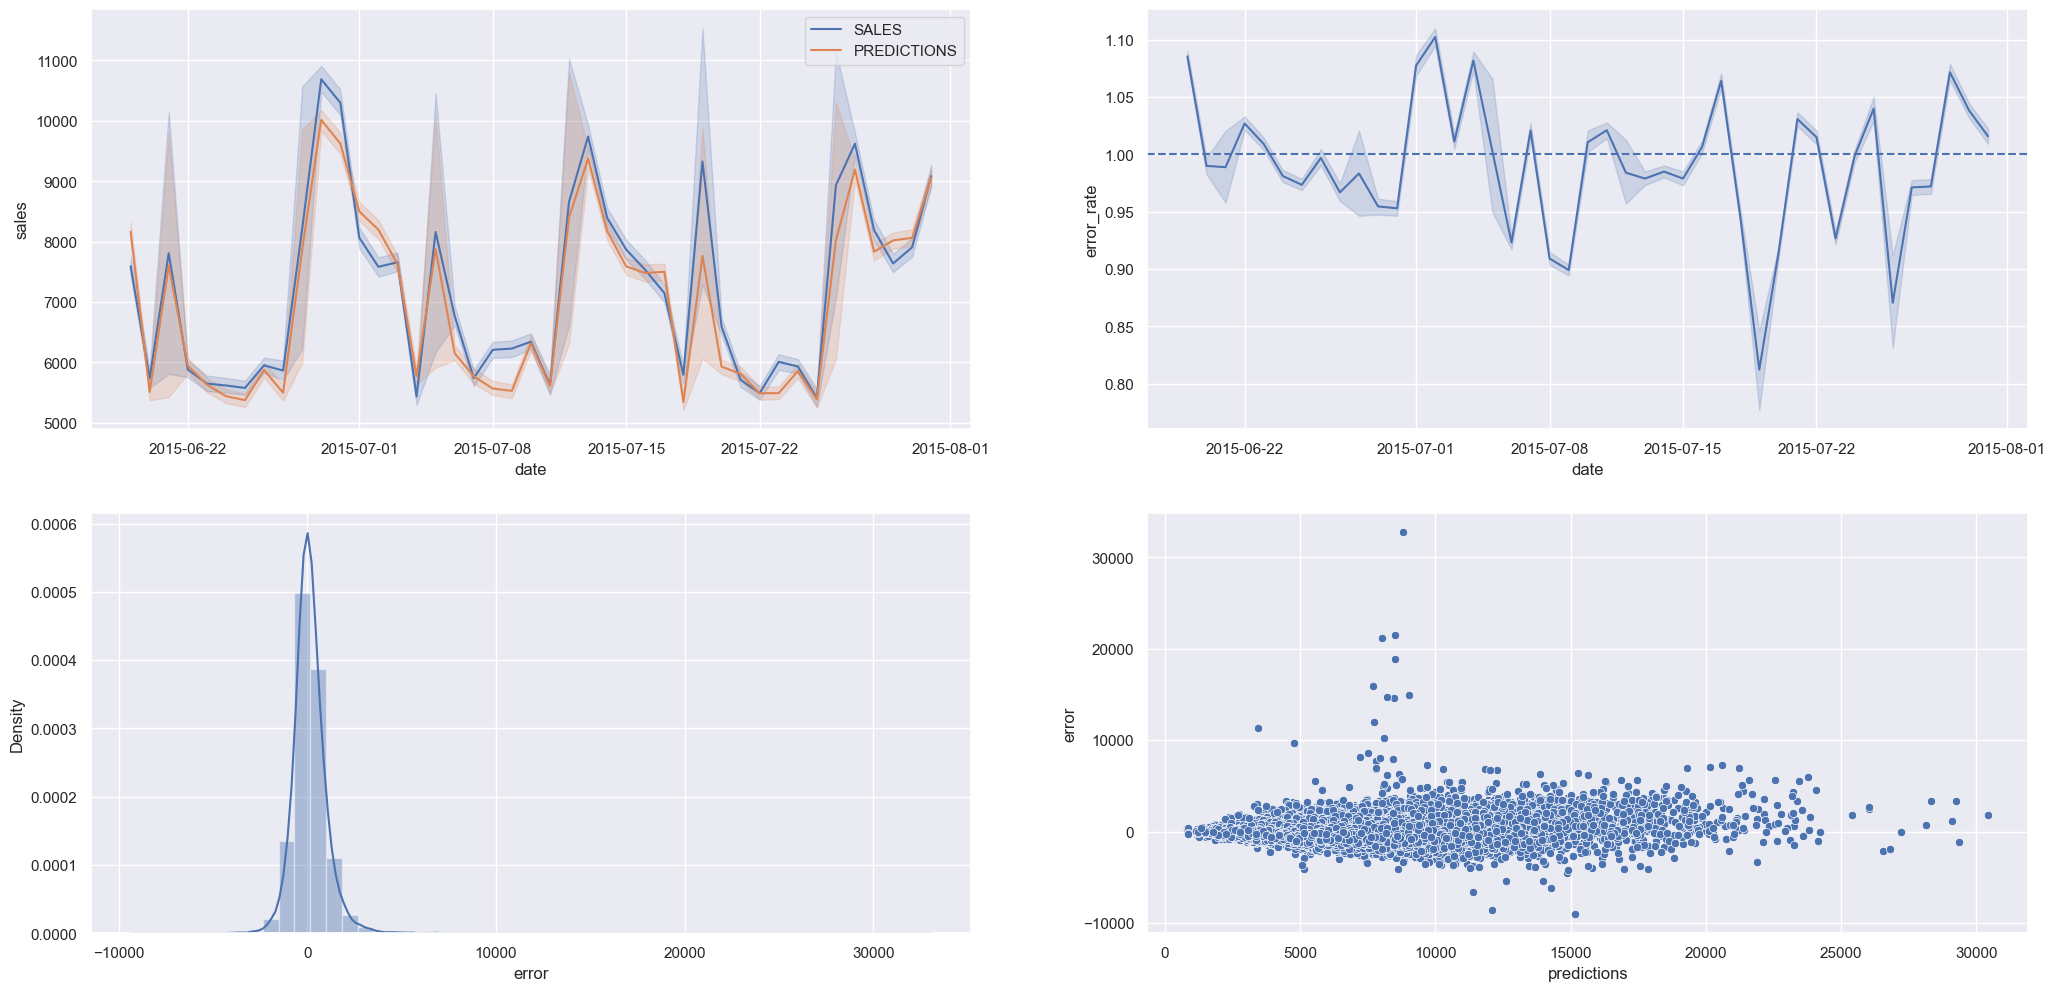

In [193]:
plt.subplot(221)
sns.lineplot(x='date', y='sales', data=df9, label='SALES' )
sns.lineplot(x='date', y='predictions', data=df9, label='PREDICTIONS')

plt.subplot(222)
sns.lineplot(x='date', y='error_rate', data=df9)
plt.axhline( 1, linestyle='--')

plt.subplot(223)
sns.distplot(df9['error'])

plt.subplot(224)
sns.scatterplot(df9['predictions'], df9['error'])

# 10.0 - DEPLOY 

In [194]:
#salvando o modelo treinado
pickle.dump(model_xgb_tuned, open('C:/Users/RafaelPC/Documents/_DS/CDS/ds_em_prod/model/model_rossmann.pkl', 'wb'))

## 10.1. Rossmann Class

In [4]:
#aqui precisa estar todas as alterações dos dados que foram feitas.


import pickle
import inflection
import pandas as pd
import numpy as np
import math
import datetime

class Rossmann( object ):
    def __init__( self ):
        self.home_path='C:/Users/RafaelPC/Documents/_DS/CDS/ds_em_prod/'
        self.competition_distance_scaler   = pickle.load( open( self.home_path + 'parameter/competition_distance_scaler.pkl', 'rb') )
        self.competition_time_month_scaler = pickle.load( open( self.home_path + 'parameter/competition_time_month_scaler.pkl', 'rb') )
        self.promo_time_week_scaler        = pickle.load( open( self.home_path + 'parameter/promo_time_week_scaler.pkl', 'rb') )
        self.year_scaler                   = pickle.load( open( self.home_path + 'parameter/year_scaler.pkl', 'rb') )
        self.store_type_scaler             = pickle.load( open( self.home_path + 'parameter/store_type_scaler.pkl', 'rb') )
        
        
    def data_cleaning( self, df1 ): 
        
        ## 1.1. Rename Columns
        cols_old = ['Store', 'DayOfWeek', 'Date', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday', 
                    'StoreType', 'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth',
                    'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']

        snakecase = lambda x: inflection.underscore( x )

        cols_new = list( map( snakecase, cols_old ) )

        # rename
        df1.columns = cols_new

        ## 1.3. Data Types
        df1['date'] = pd.to_datetime( df1['date'] )

        ## 1.5. Fillout NA
        #competition_distance        
        df1['competition_distance'] = df1['competition_distance'].apply( lambda x: 200000.0 if math.isnan( x ) else x )

        #competition_open_since_month
        df1['competition_open_since_month'] = df1.apply( lambda x: x['date'].month if math.isnan( x['competition_open_since_month'] ) else x['competition_open_since_month'], axis=1 )

        #competition_open_since_year 
        df1['competition_open_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['competition_open_since_year'] ) else x['competition_open_since_year'], axis=1 )

        #promo2_since_week           
        df1['promo2_since_week'] = df1.apply( lambda x: x['date'].week if math.isnan( x['promo2_since_week'] ) else x['promo2_since_week'], axis=1 )

        #promo2_since_year           
        df1['promo2_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['promo2_since_year'] ) else x['promo2_since_year'], axis=1 )

        #promo_interval              
        month_map = {1: 'Jan',  2: 'Fev',  3: 'Mar',  4: 'Apr',  5: 'May',  6: 'Jun',  7: 'Jul',  8: 'Aug',  9: 'Sep',  10: 'Oct', 11: 'Nov', 12: 'Dec'}

        df1['promo_interval'].fillna(0, inplace=True )

        df1['month_map'] = df1['date'].dt.month.map( month_map )

        df1['is_promo'] = df1[['promo_interval', 'month_map']].apply( lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split( ',' ) else 0, axis=1 )

        ## 1.6. Change Data Types
        # competiton
        df1['competition_open_since_month'] = df1['competition_open_since_month'].astype( 'int64' )
        df1['competition_open_since_year'] = df1['competition_open_since_year'].astype( 'int64' )

        # promo2
        df1['promo2_since_week'] = df1['promo2_since_week'].astype( 'int64' )
        df1['promo2_since_year'] = df1['promo2_since_year'].astype( 'int64' )
        
        return df1 


    def feature_engineering( self, df2 ):

        # year
        df2['year'] = df2['date'].dt.year

        # month
        df2['month'] = df2['date'].dt.month

        # day
        df2['day'] = df2['date'].dt.day

        # week of year
        df2['week_of_year'] = df2['date'].dt.weekofyear

        # year week
        df2['year_week'] = df2['date'].dt.strftime( '%Y-%W' )

        # competition since
        df2['competition_since'] = df2.apply( lambda x: datetime.datetime( year=x['competition_open_since_year'], month=x['competition_open_since_month'],day=1 ), axis=1 )
        df2['competition_time_month'] = ( ( df2['date'] - df2['competition_since'] )/30 ).apply( lambda x: x.days ).astype( int )

        # promo since
        df2['promo_since'] = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str )
        df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w' ) - datetime.timedelta( days=7 ) )
        df2['promo_time_week'] = ( ( df2['date'] - df2['promo_since'] )/7 ).apply( lambda x: x.days ).astype( int )

        # assortment
        df2['assortment'] = df2['assortment'].apply( lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended' )

        # state holiday
        df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day' )

        # 3.0. PASSO 03 - FILTRAGEM DE VARIÁVEIS
        ## 3.1. Filtragem das Linhas
        df2 = df2[df2['open'] != 0]

        ## 3.2. Selecao das Colunas
        cols_drop = ['open', 'promo_interval', 'month_map']
        df2 = df2.drop( cols_drop, axis=1 )
        
        return df2


    def data_preparation( self, df5 ):

        ## 5.2. Rescaling 
        # competition distance
        df5['competition_distance'] = self.competition_distance_scaler.transform( df5[['competition_distance']].values )
    
        # competition time month
        df5['competition_time_month'] = self.competition_time_month_scaler.transform( df5[['competition_time_month']].values )

        # promo time week
        df5['promo_time_week'] = self.promo_time_week_scaler.transform( df5[['promo_time_week']].values )
        
        # year
        df5['year'] = self.year_scaler.transform( df5[['year']].values )

        ### 5.3.1. Encoding
        # state_holiday - One Hot Encoding
        df5 = pd.get_dummies( df5, prefix=['state_holiday'], columns=['state_holiday'] )

        # store_type - Label Encoding
        df5['store_type'] = self.store_type_scaler.transform( df5['store_type'] )

        # assortment - Ordinal Encoding
        assortment_dict = {'basic': 1,  'extra': 2, 'extended': 3}
        df5['assortment'] = df5['assortment'].map( assortment_dict )

        
        ### 5.3.3. Nature Transformation
        # day of week
        df5['day_of_week_sin'] = df5['day_of_week'].apply( lambda x: np.sin( x * ( 2. * np.pi/7 ) ) )
        df5['day_of_week_cos'] = df5['day_of_week'].apply( lambda x: np.cos( x * ( 2. * np.pi/7 ) ) )

        # month
        df5['month_sin'] = df5['month'].apply( lambda x: np.sin( x * ( 2. * np.pi/12 ) ) )
        df5['month_cos'] = df5['month'].apply( lambda x: np.cos( x * ( 2. * np.pi/12 ) ) )

        # day 
        df5['day_sin'] = df5['day'].apply( lambda x: np.sin( x * ( 2. * np.pi/30 ) ) )
        df5['day_cos'] = df5['day'].apply( lambda x: np.cos( x * ( 2. * np.pi/30 ) ) )

        # week of year
        df5['week_of_year_sin'] = df5['week_of_year'].apply( lambda x: np.sin( x * ( 2. * np.pi/52 ) ) )
        df5['week_of_year_cos'] = df5['week_of_year'].apply( lambda x: np.cos( x * ( 2. * np.pi/52 ) ) )
        
        
        cols_selected = [ 'store', 'promo', 'store_type', 'assortment', 'competition_distance', 'competition_open_since_month',
            'competition_open_since_year', 'promo2', 'promo2_since_week', 'promo2_since_year', 'competition_time_month', 'promo_time_week',
            'day_of_week_sin', 'day_of_week_cos', 'month_sin', 'month_cos', 'day_sin', 'day_cos', 'week_of_year_sin', 'week_of_year_cos']
        
        return df5[ cols_selected ]
    
    
    def get_prediction( self, model, original_data, test_data ):
        # prediction
        pred = model.predict( test_data )
        
        # join pred into the original data
        original_data['prediction'] = np.expm1( pred )
        
        return original_data.to_json( orient='records', date_format='iso' )

## 10.2. API Handler


In [62]:
import pickle
import pandas as pd
from flask             import Flask, request, Response
from rossmann.Rossmann import Rossmann

# loading model
model = pickle.load( open( 'C:/Users/RafaelPC/Documents/_DS/CDS/ds_em_prod/model/model_rossmann.pkl', 'rb') )

# initialize API
app = Flask( __name__ )

@app.route( '/rossmann/predict', methods=['POST'] )
def rossmann_predict():
    test_json = request.get_json()
   
    if test_json: # there is data
        if isinstance( test_json, dict ): # unique example
            test_raw = pd.DataFrame( test_json, index=[0] )
            
        else: # multiple example
            test_raw = pd.DataFrame( test_json, columns=test_json[0].keys() )
            
        # Instantiate Rossmann class
        pipeline = Rossmann()
        
        # data cleaning
        df1 = pipeline.data_cleaning( test_raw )
        
        # feature engineering
        df2 = pipeline.feature_engineering( df1 )
        
        # data preparation
        df3 = pipeline.data_preparation( df2 )
        
        # prediction
        df_response = pipeline.get_prediction( model, test_raw, df3 )
        
        return df_response
        
        
    else:
        return Reponse( '{}', status=200, mimetype='application/json' )

if __name__ == '__main__':
    app.run( '0.0.0.0' )

 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on all addresses (0.0.0.0)
 * Running on http://127.0.0.1:5000
 * Running on http://192.168.100.20:5000
Press CTRL+C to quit


## 10.3. API Tester

In [10]:
# loading test dataset
df10 = pd.read_csv( 'test.csv' )

In [12]:
# merge test dataset + store
df_test = pd.merge( df10, df_store_raw, how='left', on='Store' )

# choose store for prediction
df_test = df_test[df_test['Store'].isin( [100] )]

# remove closed days
df_test = df_test[df_test['Open'] != 0]
df_test = df_test[~df_test['Open'].isnull()]
df_test = df_test.drop( 'Id', axis=1 )

In [13]:
# convert Dataframe to json
data = json.dumps( df_test.to_dict( orient='records' ) )

In [14]:
# API Call
#url = 'http://127.0.0.1:5000/rossmann/predict'
url = 'https://rossmann-prdct.herokuapp.com/rossmann/predict'
header = {'Content-type': 'application/json' } 
data = data

r = requests.post( url, data=data, headers=header )
print( 'Status Code {}'.format( r.status_code ) )

Status Code 200


In [15]:
d1 = pd.DataFrame( r.json(), columns=r.json()[0].keys() ) # conversão de jason para dataframe

In [31]:
d2 = d1[['store', 'prediction']].groupby( 'store' ).sum().reset_index()

for i in range( len( d2 ) ):
    print( 'Loja Nº {} venderá R${:,.2f} nas próximas 6 semanas'.format( 
            d2.loc[i, 'store'], 
            d2.loc[i, 'prediction'] ) )

Loja Nº 100 venderá R$221,057.60 nas próximas 6 semanas


In [33]:
import sys

In [34]:
print(sys.executable)
print(sys.version)
print(sys.version_info)

C:\Users\RafaelPC\anaconda3\envs\ross\python.exe
3.9.13 (main, Aug 25 2022, 23:51:50) [MSC v.1916 64 bit (AMD64)]
sys.version_info(major=3, minor=9, micro=13, releaselevel='final', serial=0)
